# Cálculo de distancia entre puntos y caracterización previa de los movimientos

En este Notebook se calculan las distancias entre puntos del cuerpo y los ángulos de las distintas articulaciones según el gesto que esté realizando el paciente. Por ejemplo, si se detecta una flexión del hombro derecho, se calcularán las distancias ángulos relacionados con ese brazo.

Una vez realizados estos cálculos, se llevará a cabo una nueva hiperparametrización del pipeline de la Fase 2, con el objetivo de evaluar si esto mejora el rendimiento del modelo.

Finalmente, para comprender cómo se clasifica cada repetición de los gestos como correcta o incorrecta, se generarán gráficos que visualicen la importancia de las variables seleccionadas y cómo estas son utilizadas por el clasificador.


<div style="text-align: center;">
<img src="../Imagenes/gestures.png" width="500"/>
</div>

***• Importar librerías***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fn
import numpy as np
from sklearn import tree # visualizar dtree
from scipy.special import expit # visualizar LogisticRegression

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import LeaveOneGroupOut # LeavePGroupsOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV

# Class imbalance
from imblearn.under_sampling import NearMiss, EditedNearestNeighbours
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance


# Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.compose import ColumnTransformer

# Suprimir warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

***• Importar datos***

In [2]:
# Dataframe de los datos en bruto
df_raw = pd.read_csv('../Resultados/raw_pacientes.csv', dtype=object)
df_raw 

SubjectID GestureLabel GestureName RepetitionNumber CorrectLabel  \
0             102            0         EFL               10            1   
1             102            0         EFL               10            1   
2             102            0         EFL               10            1   
3             102            0         EFL               10            1   
4             102            0         EFL               10            1   
...           ...          ...         ...              ...          ...   
5500495       307            8         STR                9            1   
5500496       307            8         STR                9            1   
5500497       307            8         STR                9            1   
5500498       307            8         STR                9            1   
5500499       307            8         STR                9            1   

        Position      JointName         3D_X         3D_Y      3D_Z  
0          chair      SpineBase  -0.08088344   -0.2248836  2.661578  
1          chair       SpineMid  -0.06806522   0.04492111  2.628779  
2          chair           Neck    -0.055614    0.3082771  2.583972  
3          chair           Head  -0.04478608    0.4328104  2.593495  
4          chair   ShoulderLeft   -0.2232155    0.2021449  2.549825  
...          ...            ...          ...          ...       ...  
5500495    stand  SpineShoulder  -0.05799517    0.5291457  2.422904  
5500496    stand    HandTipLeft    -0.302538   -0.1131345  2.284269  
5500497    stand      ThumbLeft   -0.2783904  -0.06298634  2.269769  
5500498    stand   HandTipRight    0.1525867    -0.136378   2.45287  
5500499    stand     ThumbRight    0.1846331  -0.06777165  2.436065  

[5500500 rows x 10 columns]

***• Funciones creadas***

In [3]:
def calcular_distancia(df: pd.DataFrame, joint_a: str, joint_b: str):
    # Extraer posiciones de los keypoints
    positions = df.set_index('JointName')[['3D_X', '3D_Y', '3D_Z']].loc[[joint_a, joint_b]]

    # Convertir las posiciones a tipo numérico
    positions = positions.apply(pd.to_numeric)

    # Vector u (joint_a to joint_b) y Vector v (joint_b to joint_c)
    u = np.array([positions.iloc[1, 0] - positions.iloc[0, 0],
                  positions.iloc[1, 1] - positions.iloc[0, 1],
                  positions.iloc[1, 2] - positions.iloc[0, 2]])

    modulo_u = np.linalg.norm(u)

    return modulo_u

In [4]:
# dividir en test y train df_gestures
def split_df_gestures(df:pd.DataFrame, target: str):

    # Selecciona los datos de prueba (varios sujetos)
    test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
                (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==211) |(df.SubjectID==301) | (df.SubjectID==302)] 

    # Selecciona los datos de entrenamiento excluyendo los mismos sujetos
    train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                    (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=211) & (df.SubjectID!=301) & (df.SubjectID!=302)]

    # Separa las características y las etiquetas en el conjunto de entrenamiento
    X_train = train_df.drop([target], axis=1)  
    y_train = pd.DataFrame(train_df[target])   

    # Separa las características y las etiquetas en el conjunto de prueba
    X_test = test_df.drop([target], axis=1)  
    y_test = pd.DataFrame(test_df[target])   

    # Convierte los DataFrames de etiquetas a arrays 1D
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Devuelve los conjuntos de entrenamiento y prueba
    return X_train, X_test, y_train, y_test

***• Caracterización previa de los movimientos y Pipeline***

In [5]:
# Definir la malla de parámetros
param_grid = [
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5], 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [SVC(probability=True)],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [200, 300],
        'classifier__max_features': ['sqrt', 'log2']
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    }
]


------------ CLASIFICACION GESTO EFL -----------

F1-score del conjunto de entrenamiento: 0.9166666666666666
F1-score del conjunto de prueba: 0.8840579710144928
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=8)),
                ('classifier', SVC(C=0.1, kernel='sigmoid', probability=True))])


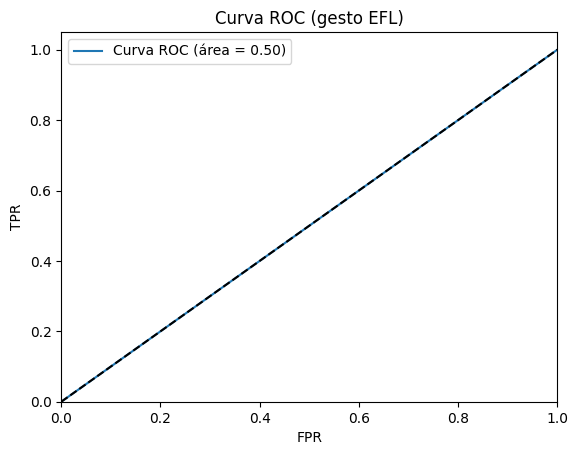

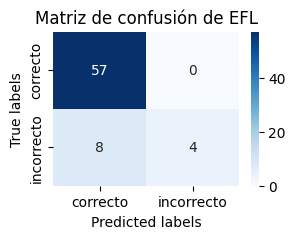

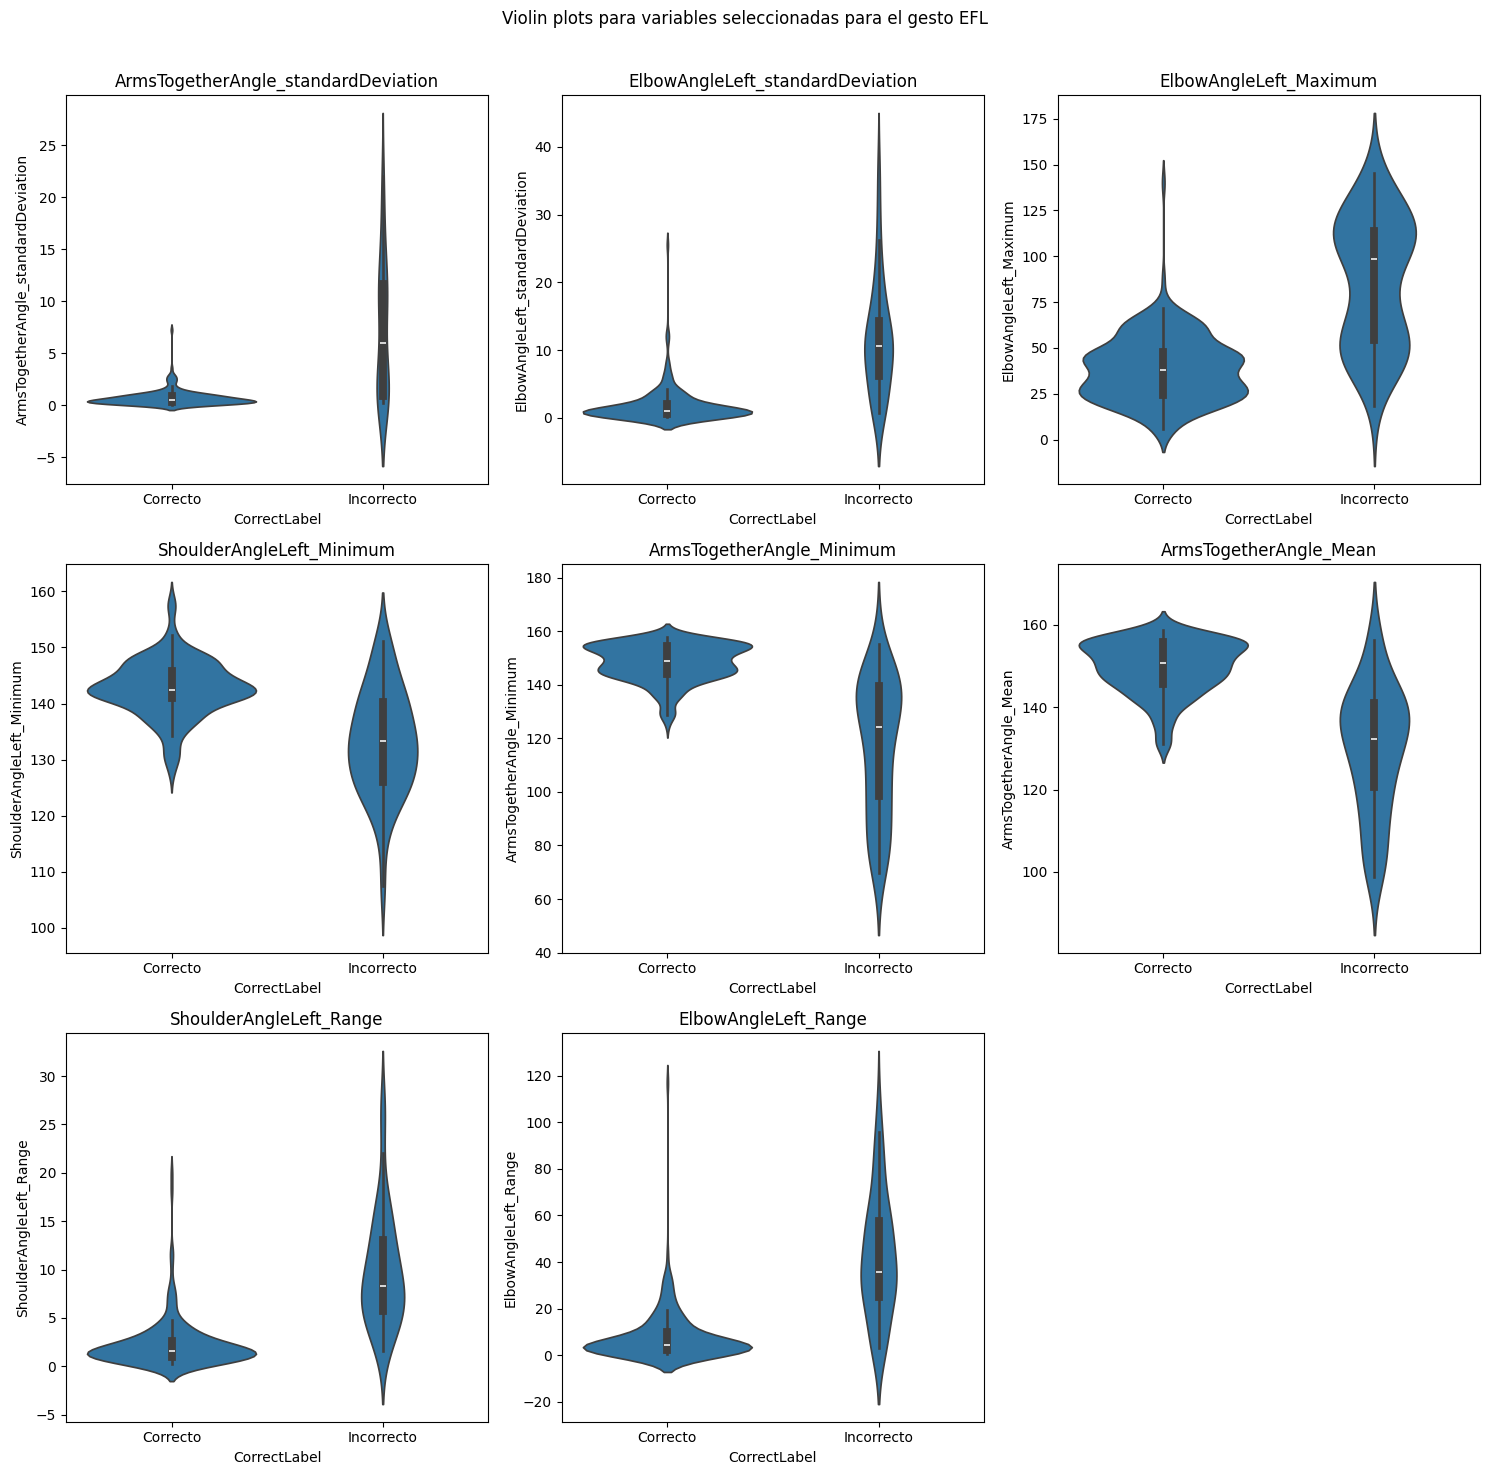

<Figure size 640x480 with 0 Axes>

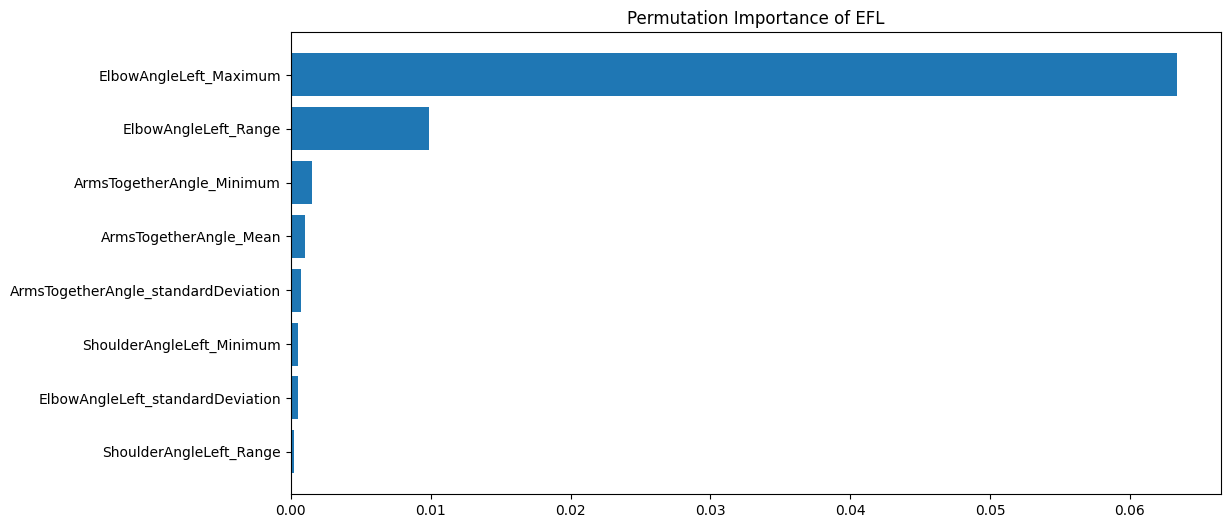


------------ CLASIFICACION GESTO EFR -----------



C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


F1-score del conjunto de entrenamiento: 0.8715083798882681
F1-score del conjunto de prueba: 0.8735632183908046
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest()),
                ('classifier', GaussianNB(var_smoothing=0.07390722033525775))])


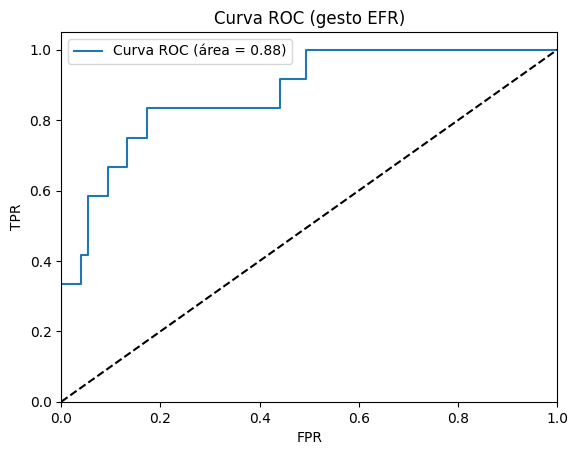

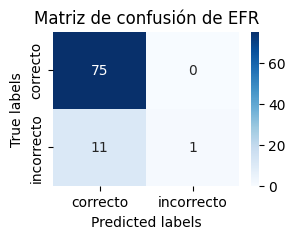

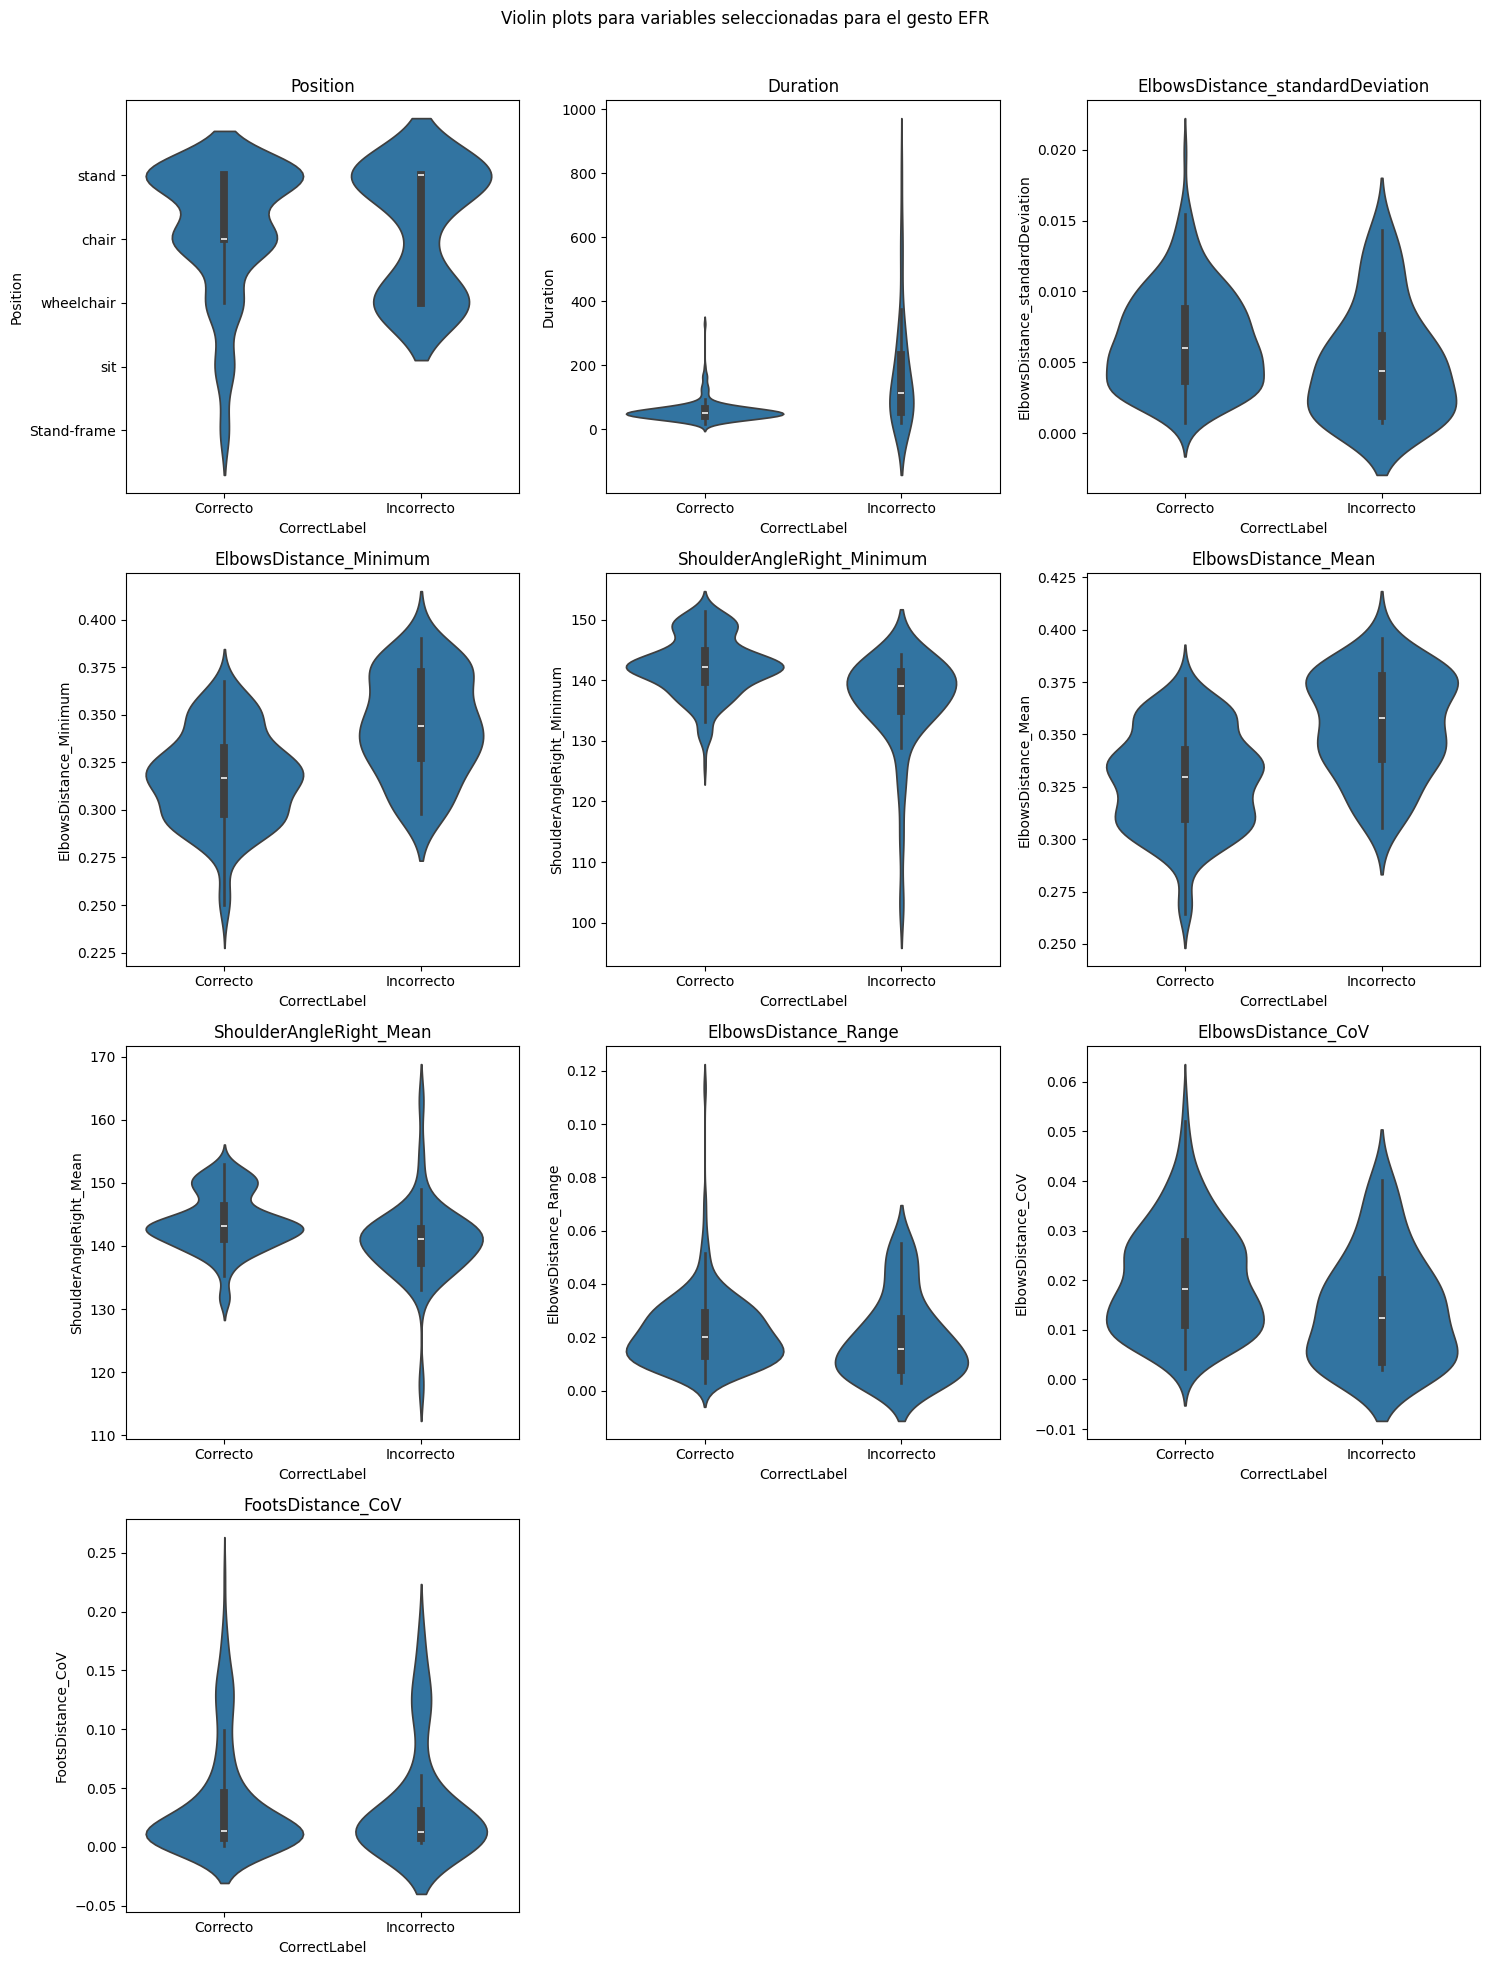

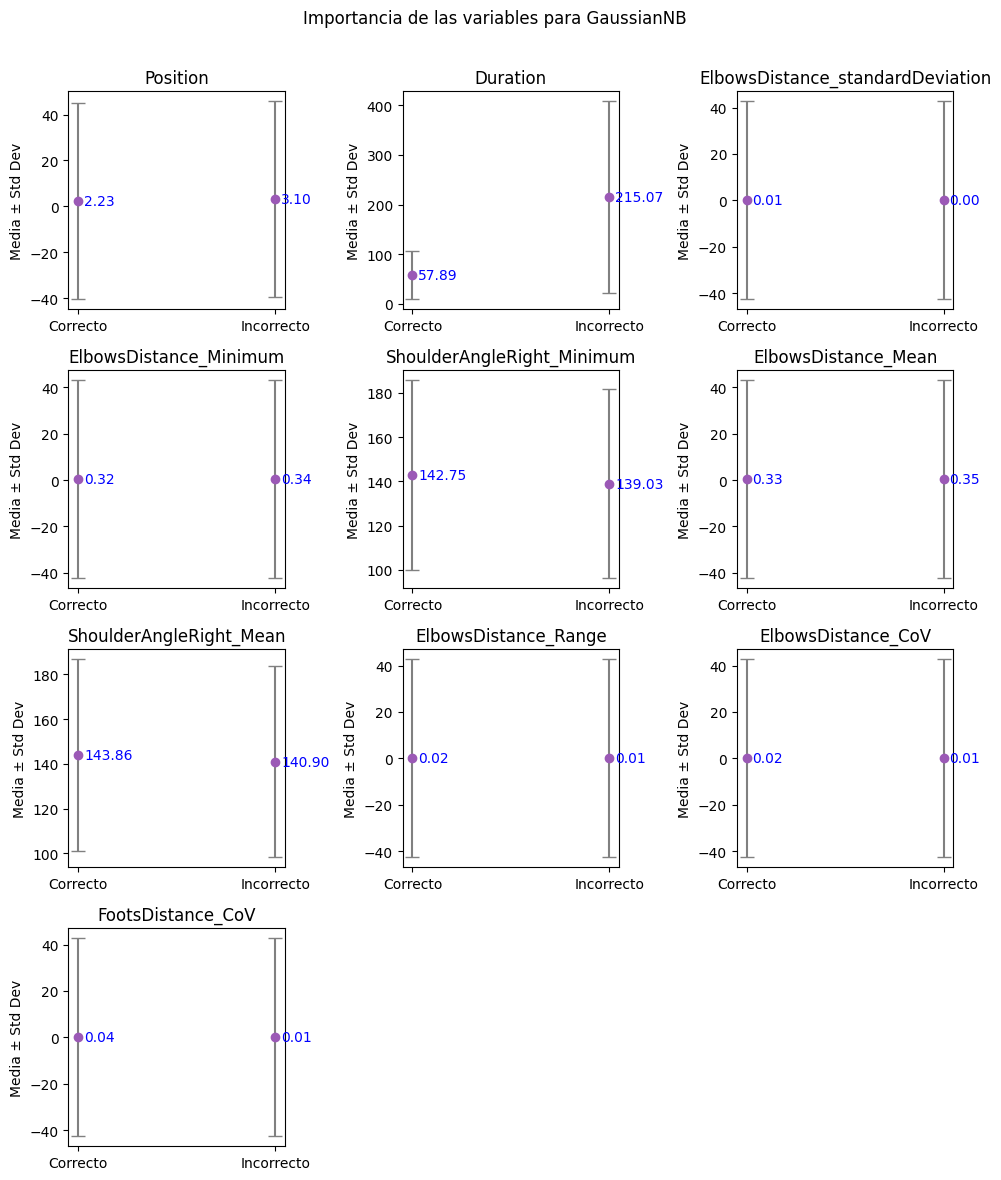


------------ CLASIFICACION GESTO SFL -----------

F1-score del conjunto de entrenamiento: 0.908745247148289
F1-score del conjunto de prueba: 0.8415841584158416
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=9)),
                ('classifier',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3,
                                      weights='distance'))])


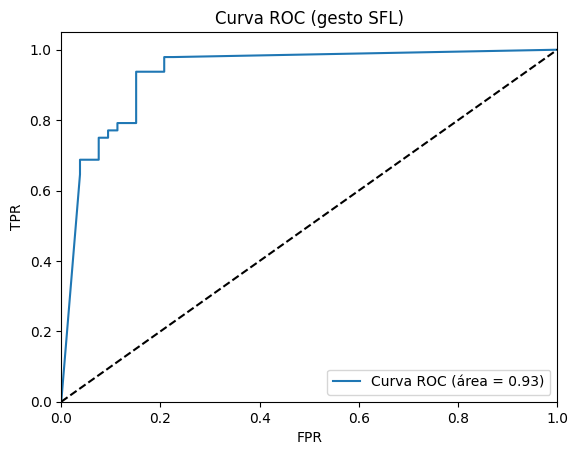

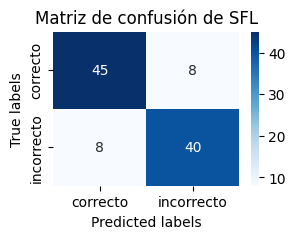

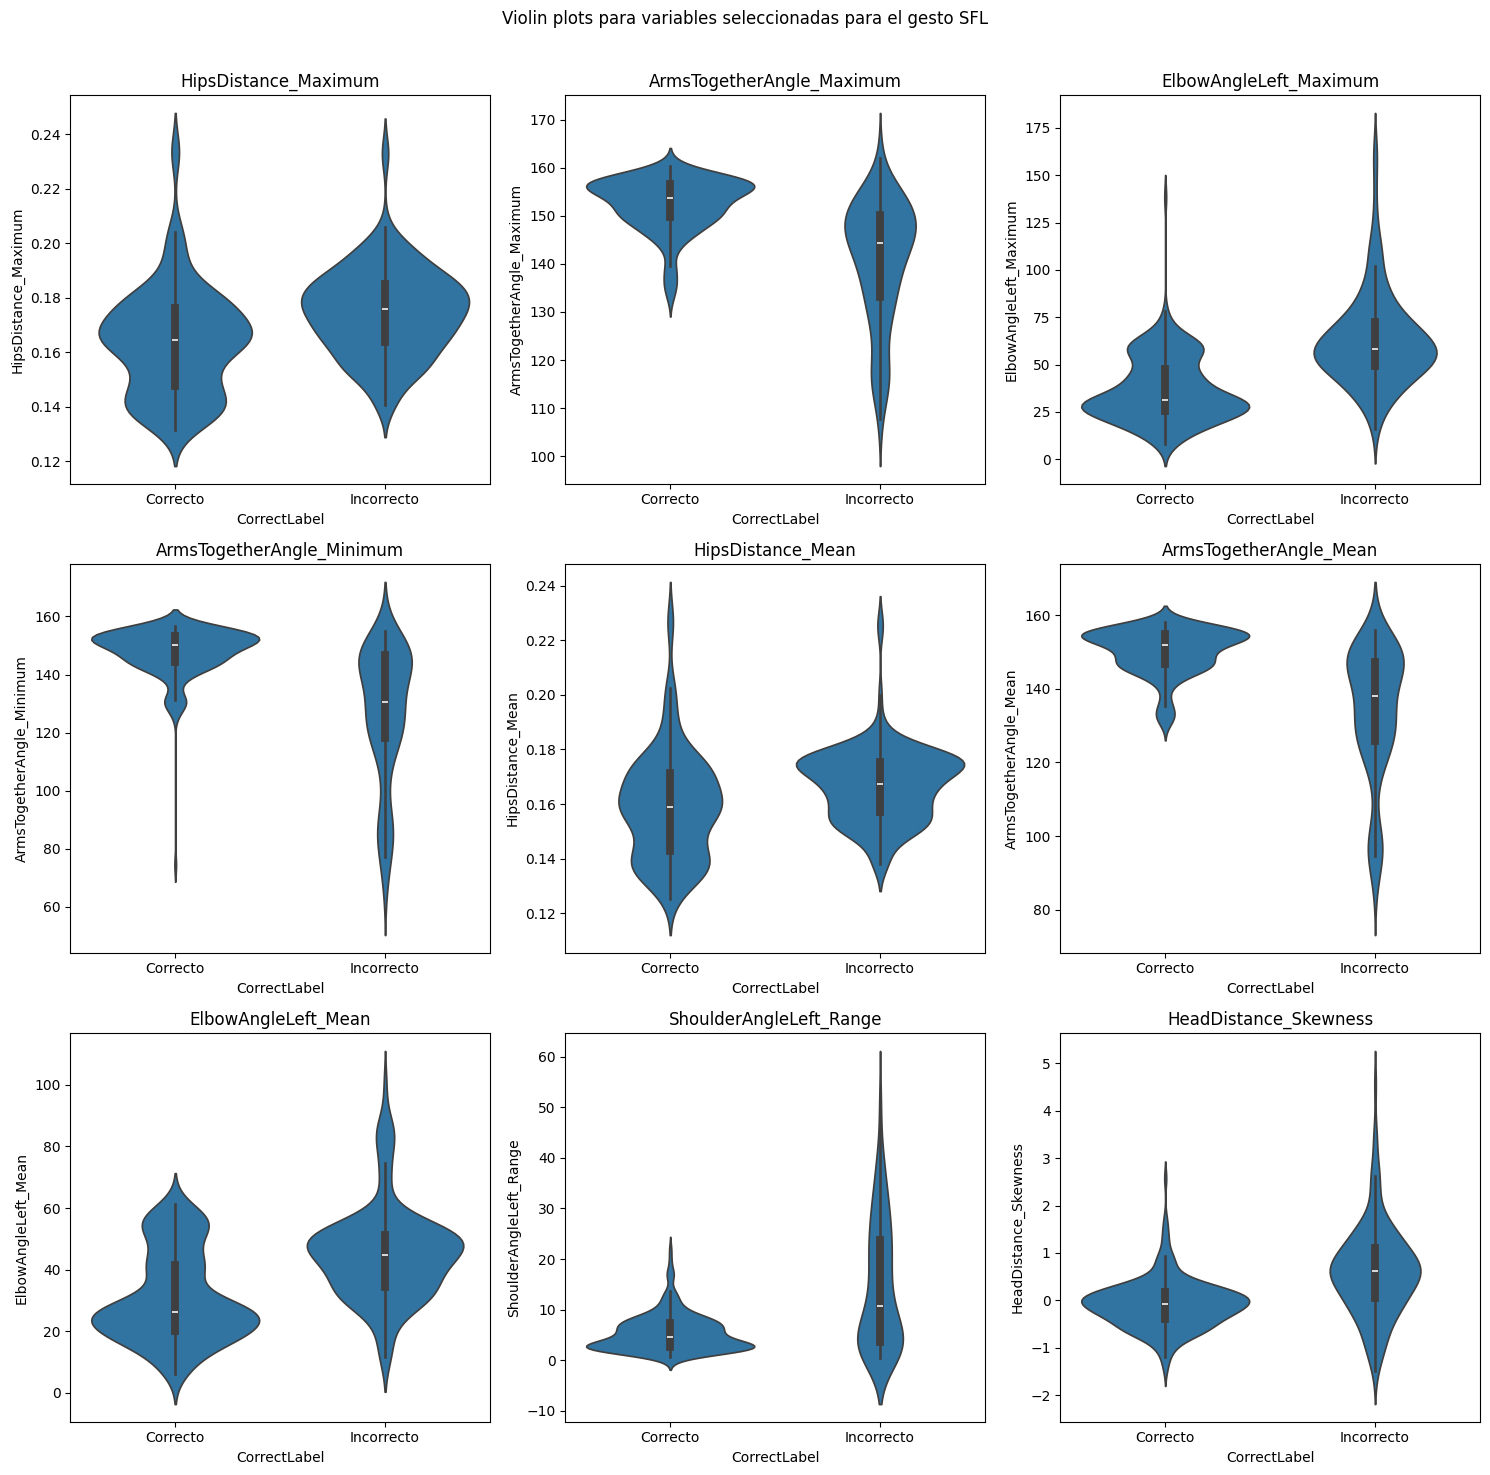

<Figure size 640x480 with 0 Axes>

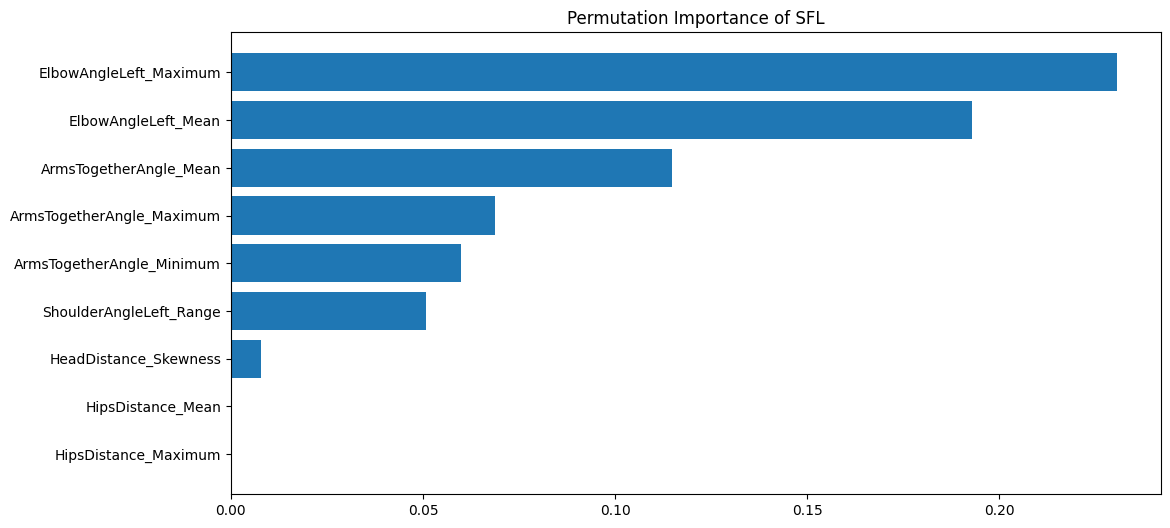


------------ CLASIFICACION GESTO SFR -----------



C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


F1-score del conjunto de entrenamiento: 0.9698275862068966
F1-score del conjunto de prueba: 0.8378378378378378
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=11)),
                ('classifier', RandomForestClassifier(n_estimators=200))])


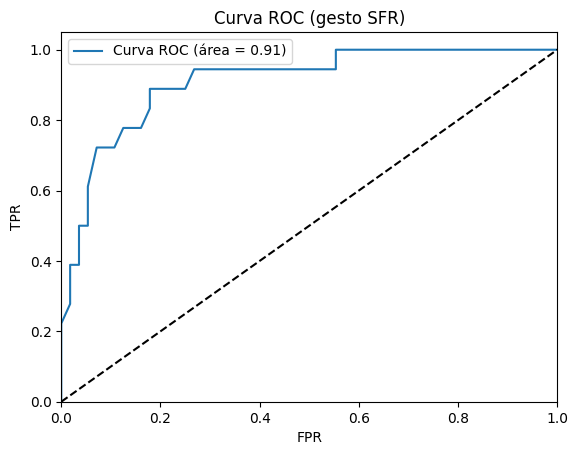

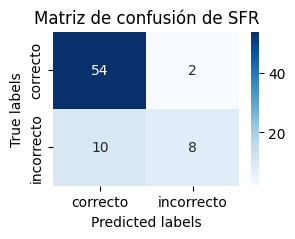

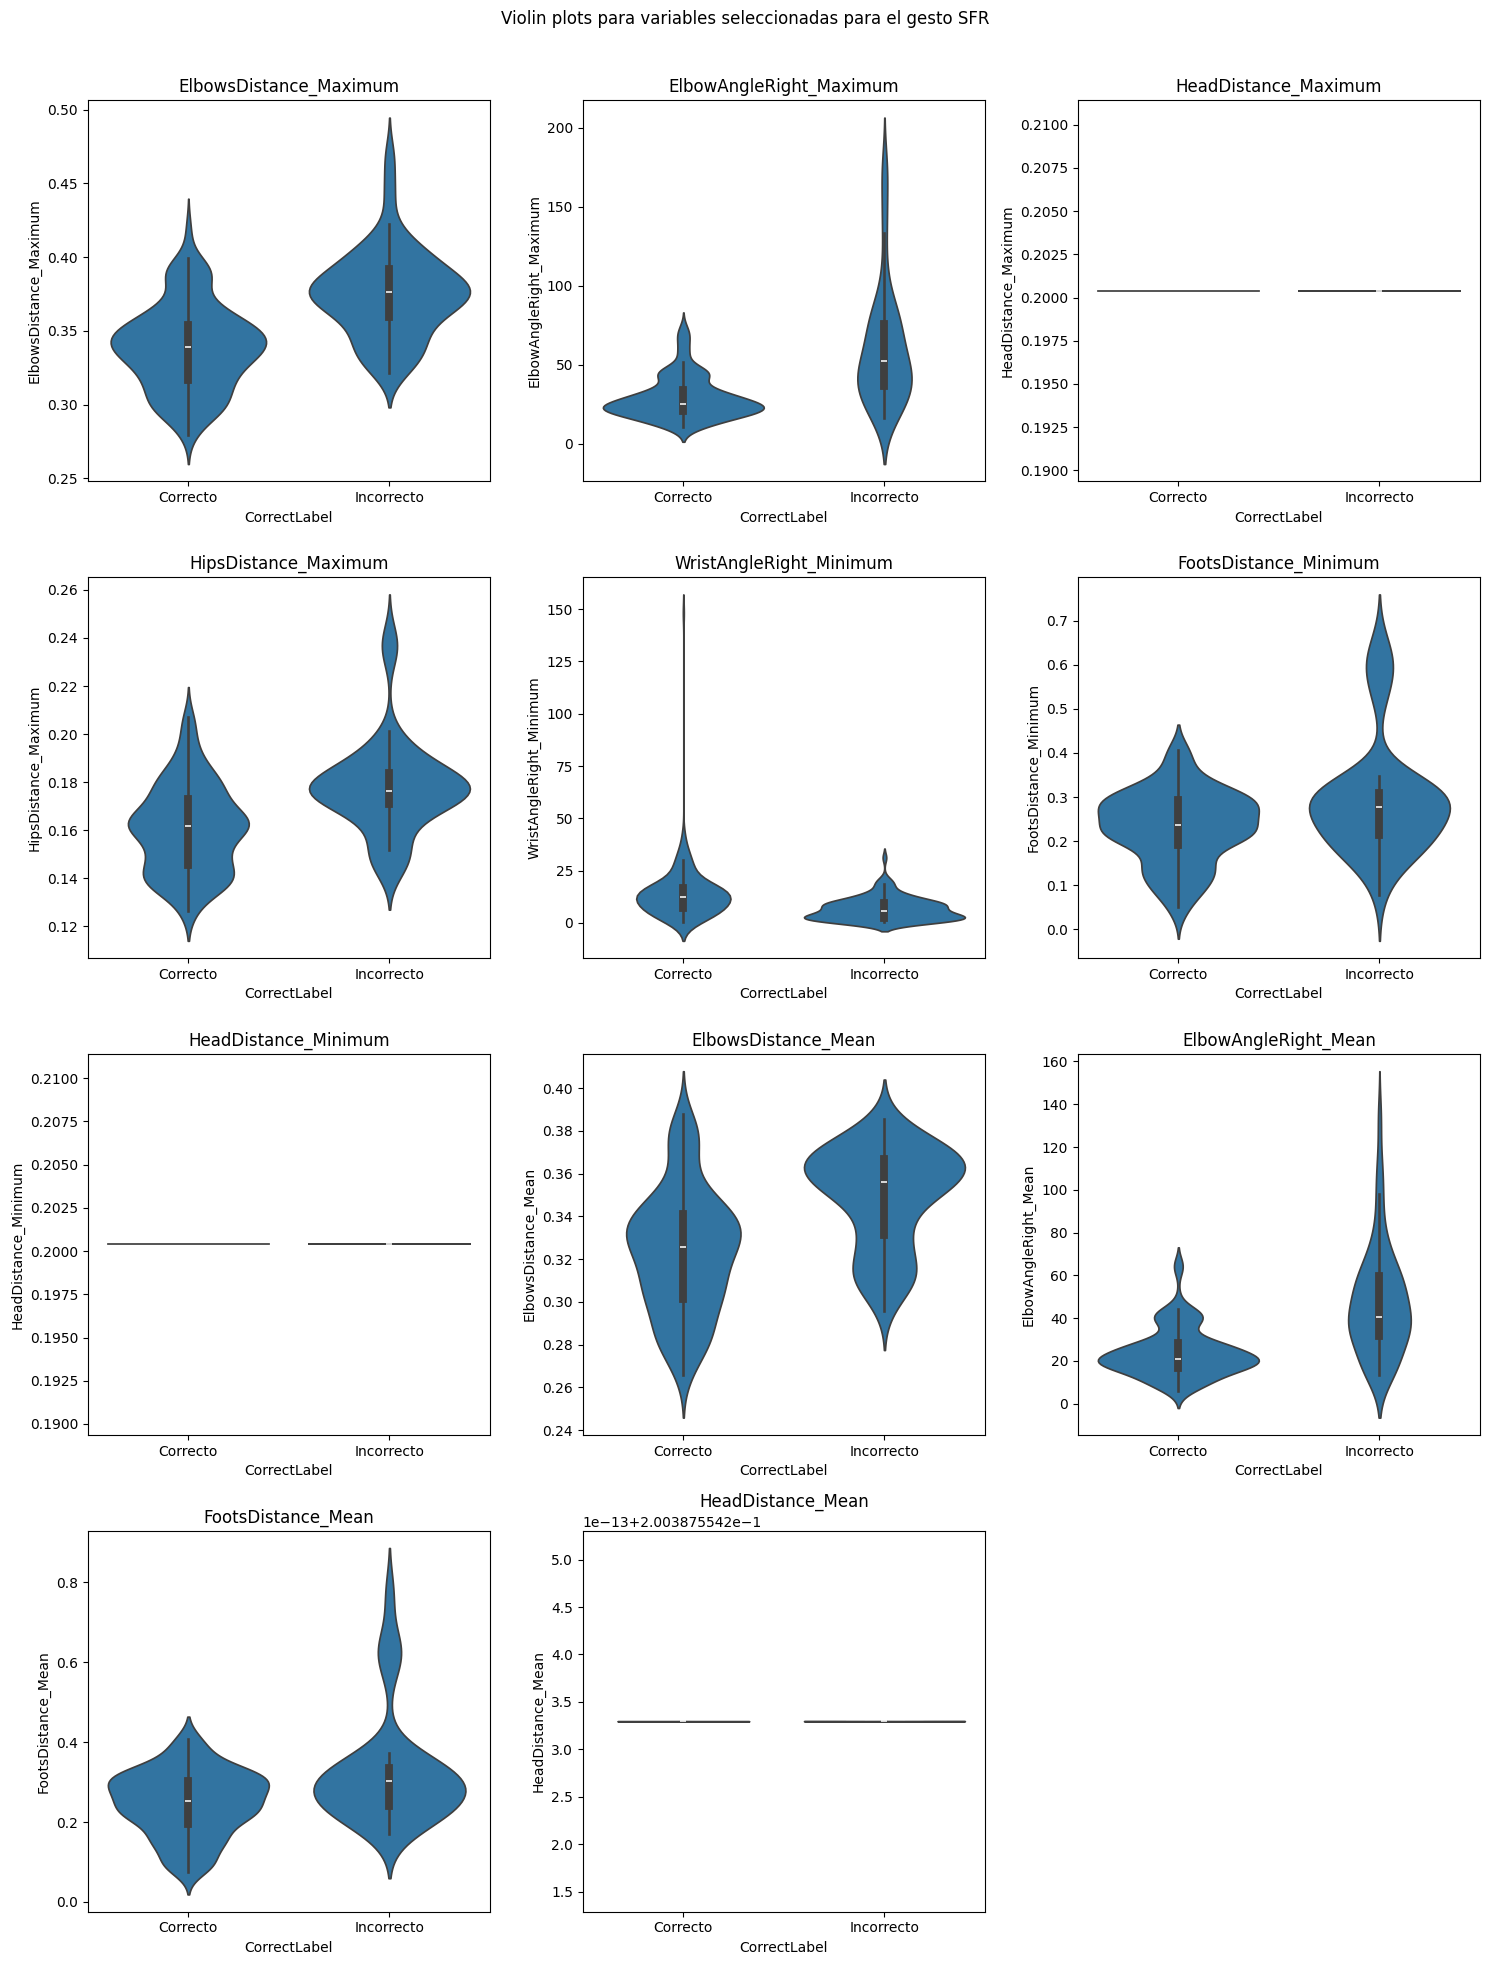

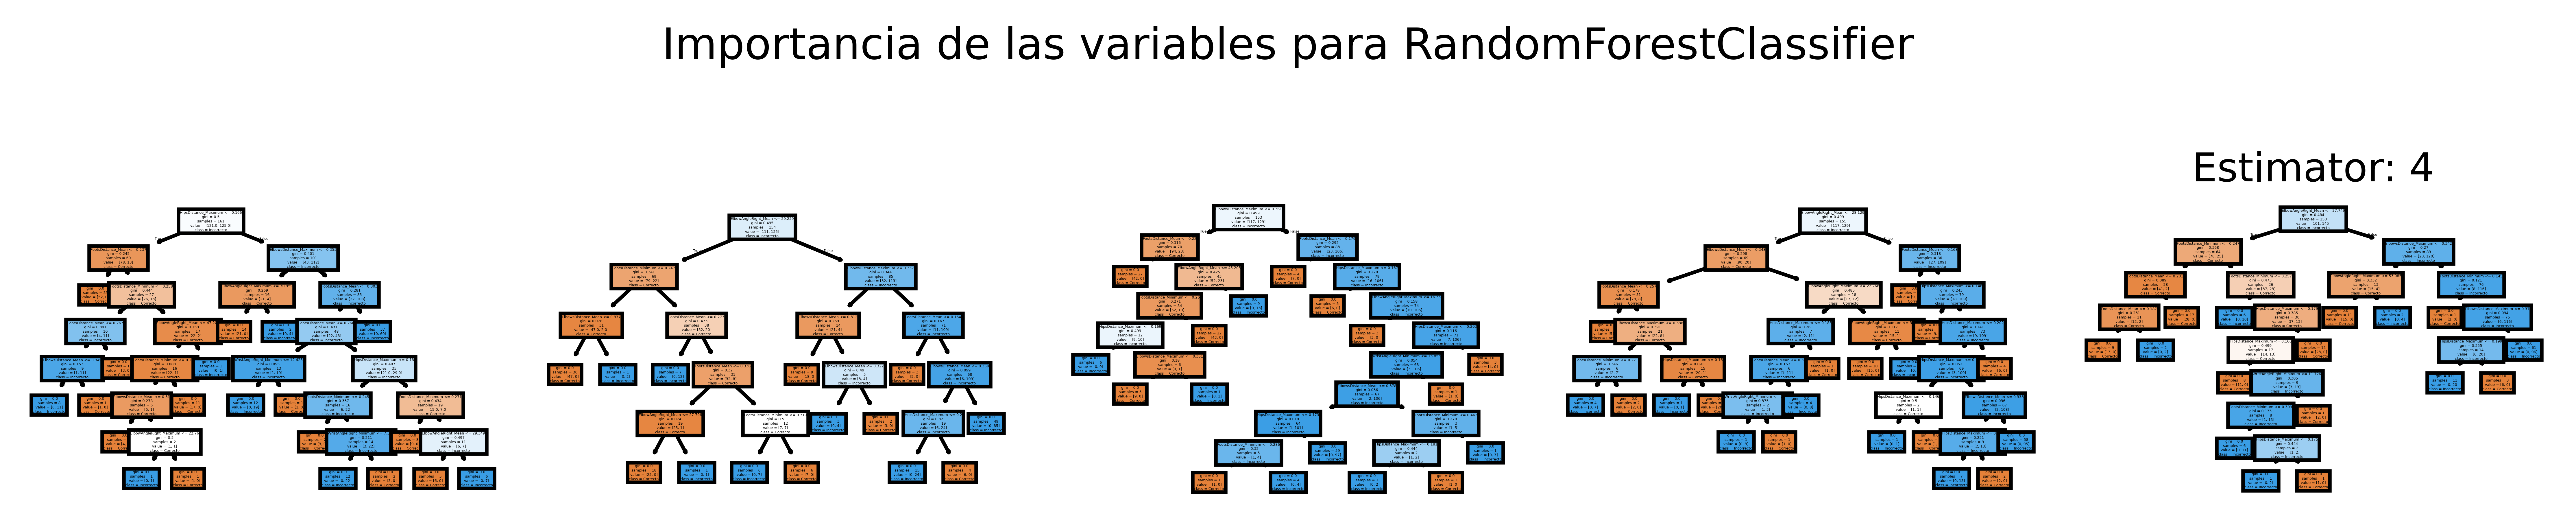

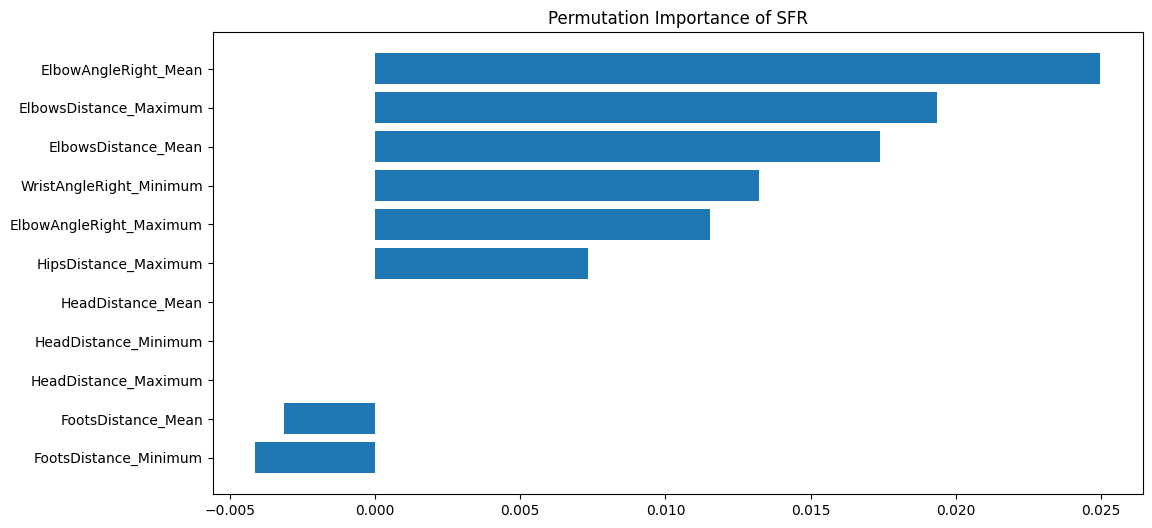


------------ CLASIFICACION GESTO SAL -----------

F1-score del conjunto de entrenamiento: 0.8424242424242424
F1-score del conjunto de prueba: 0.65
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=13)),
                ('classifier',
                 GaussianNB(var_smoothing=1.2618568830660185e-06))])


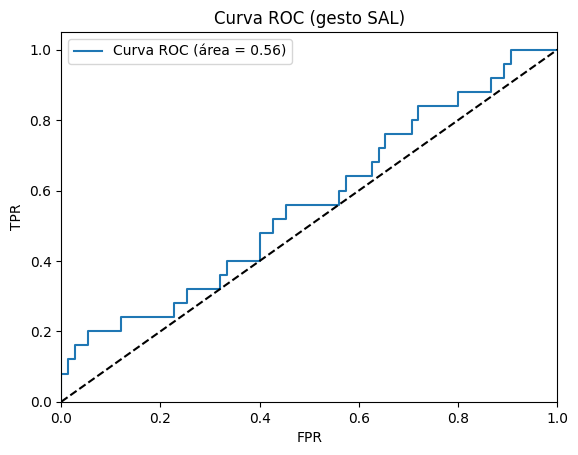

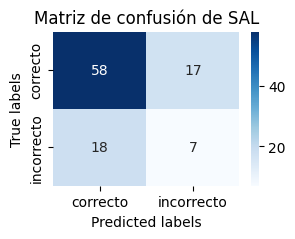

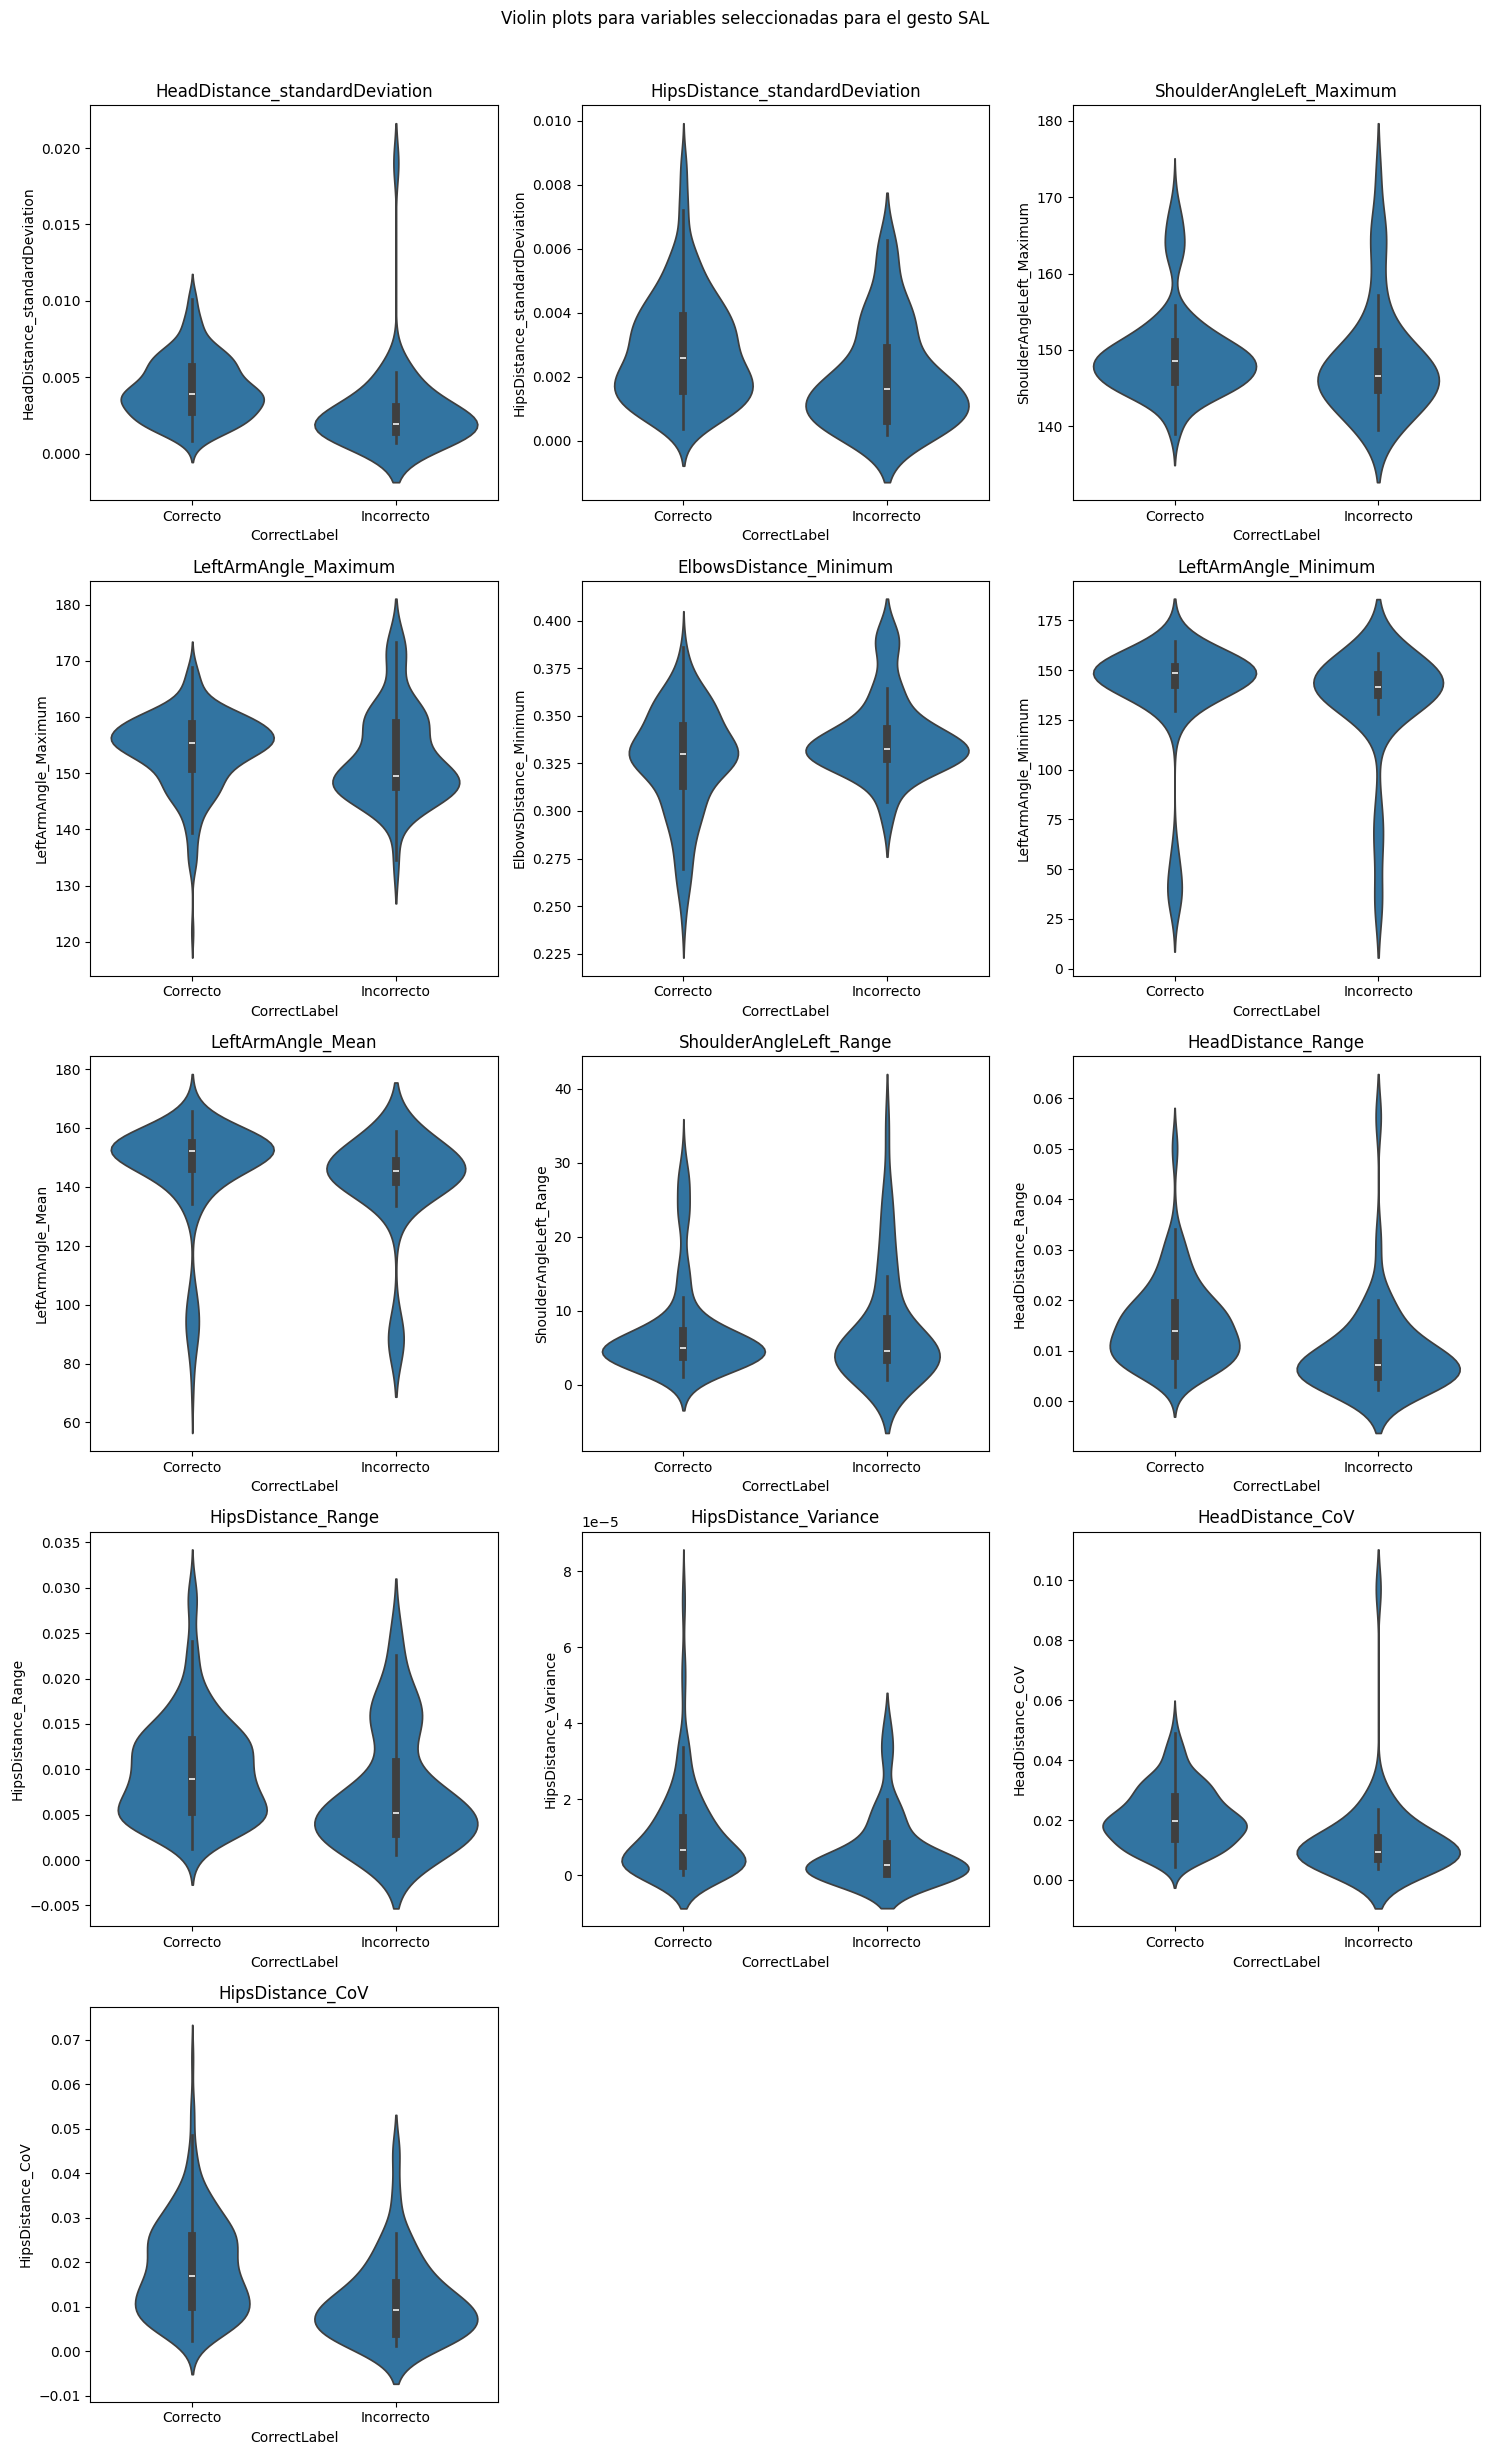

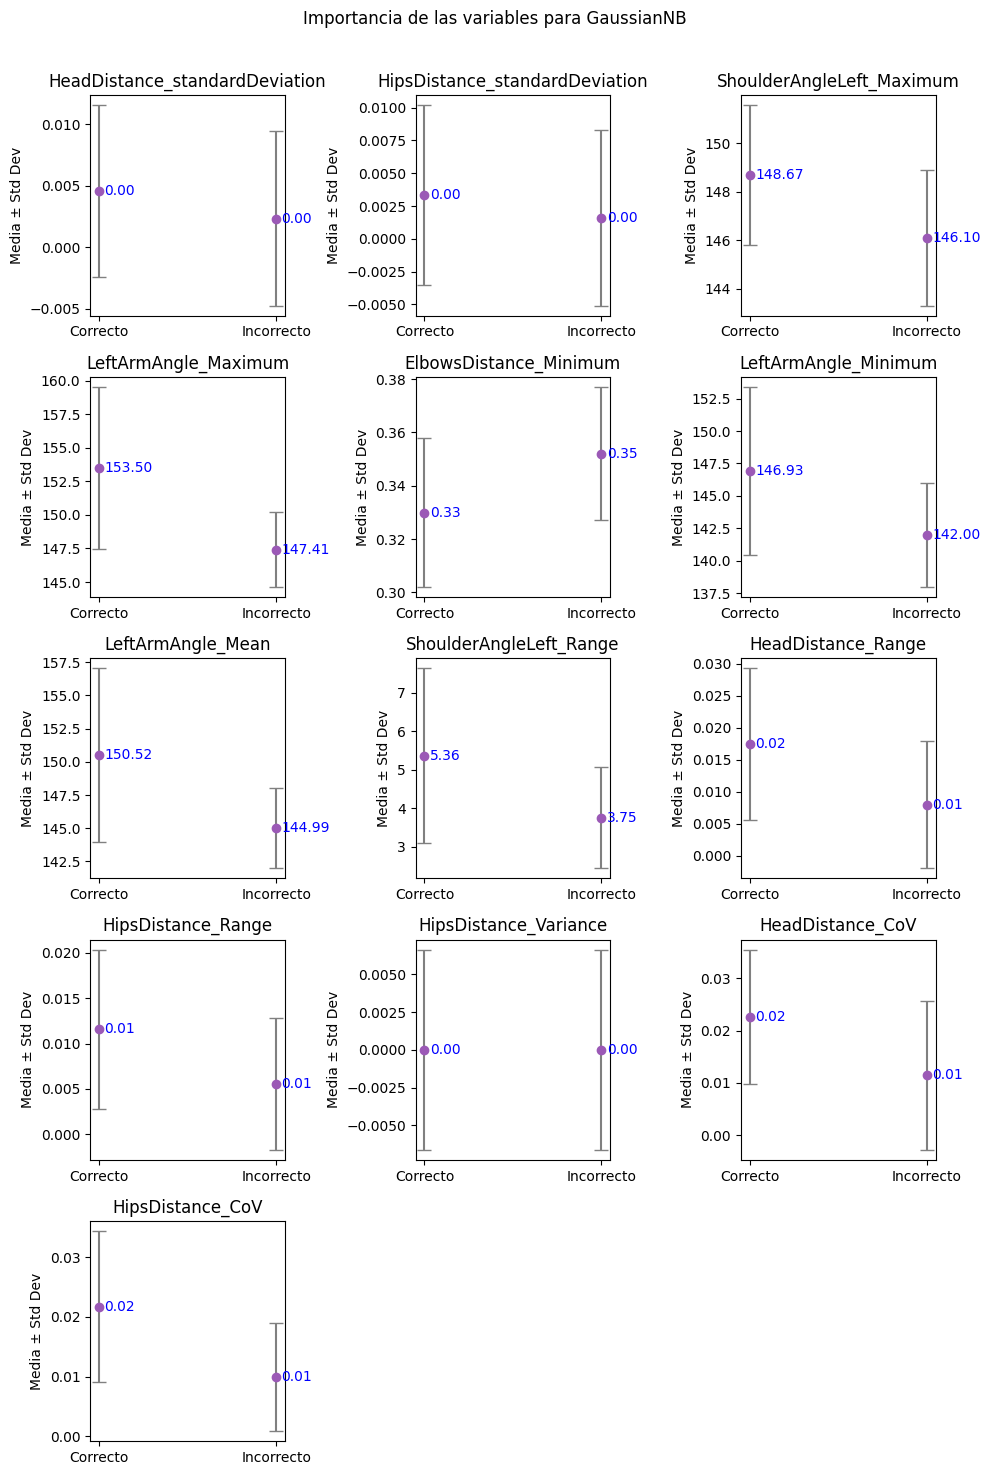

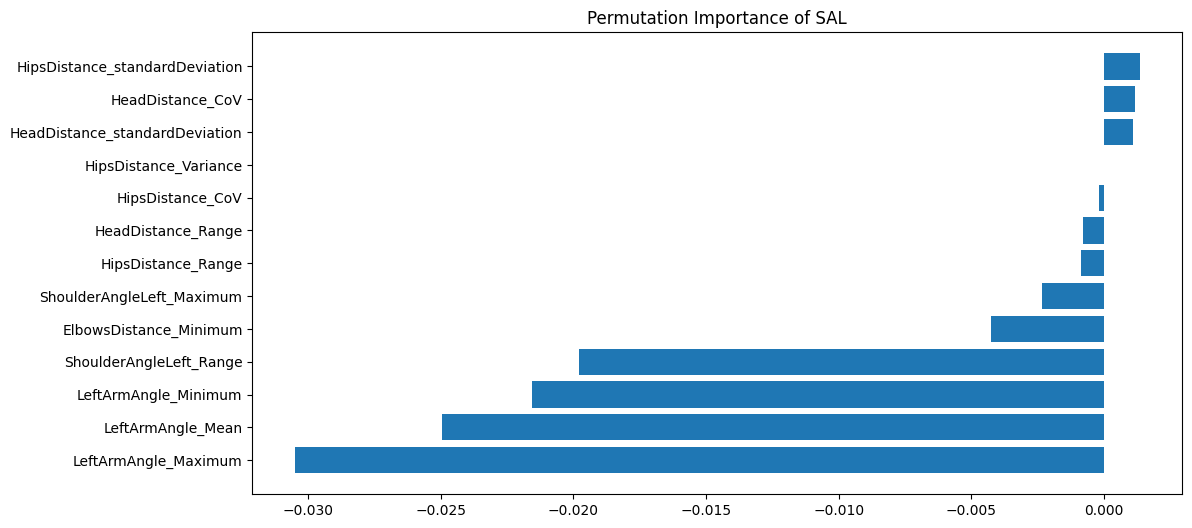


------------ CLASIFICACION GESTO SAR -----------



C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


F1-score del conjunto de entrenamiento: 0.8369565217391305
F1-score del conjunto de prueba: 0.7666666666666667
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=4, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=11)),
                ('classifier', DecisionTreeClassifier(criterion='entropy'))])


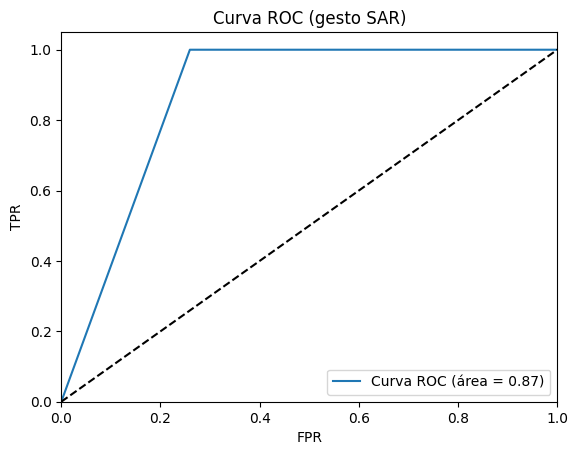

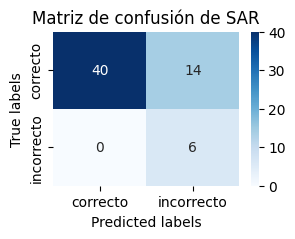

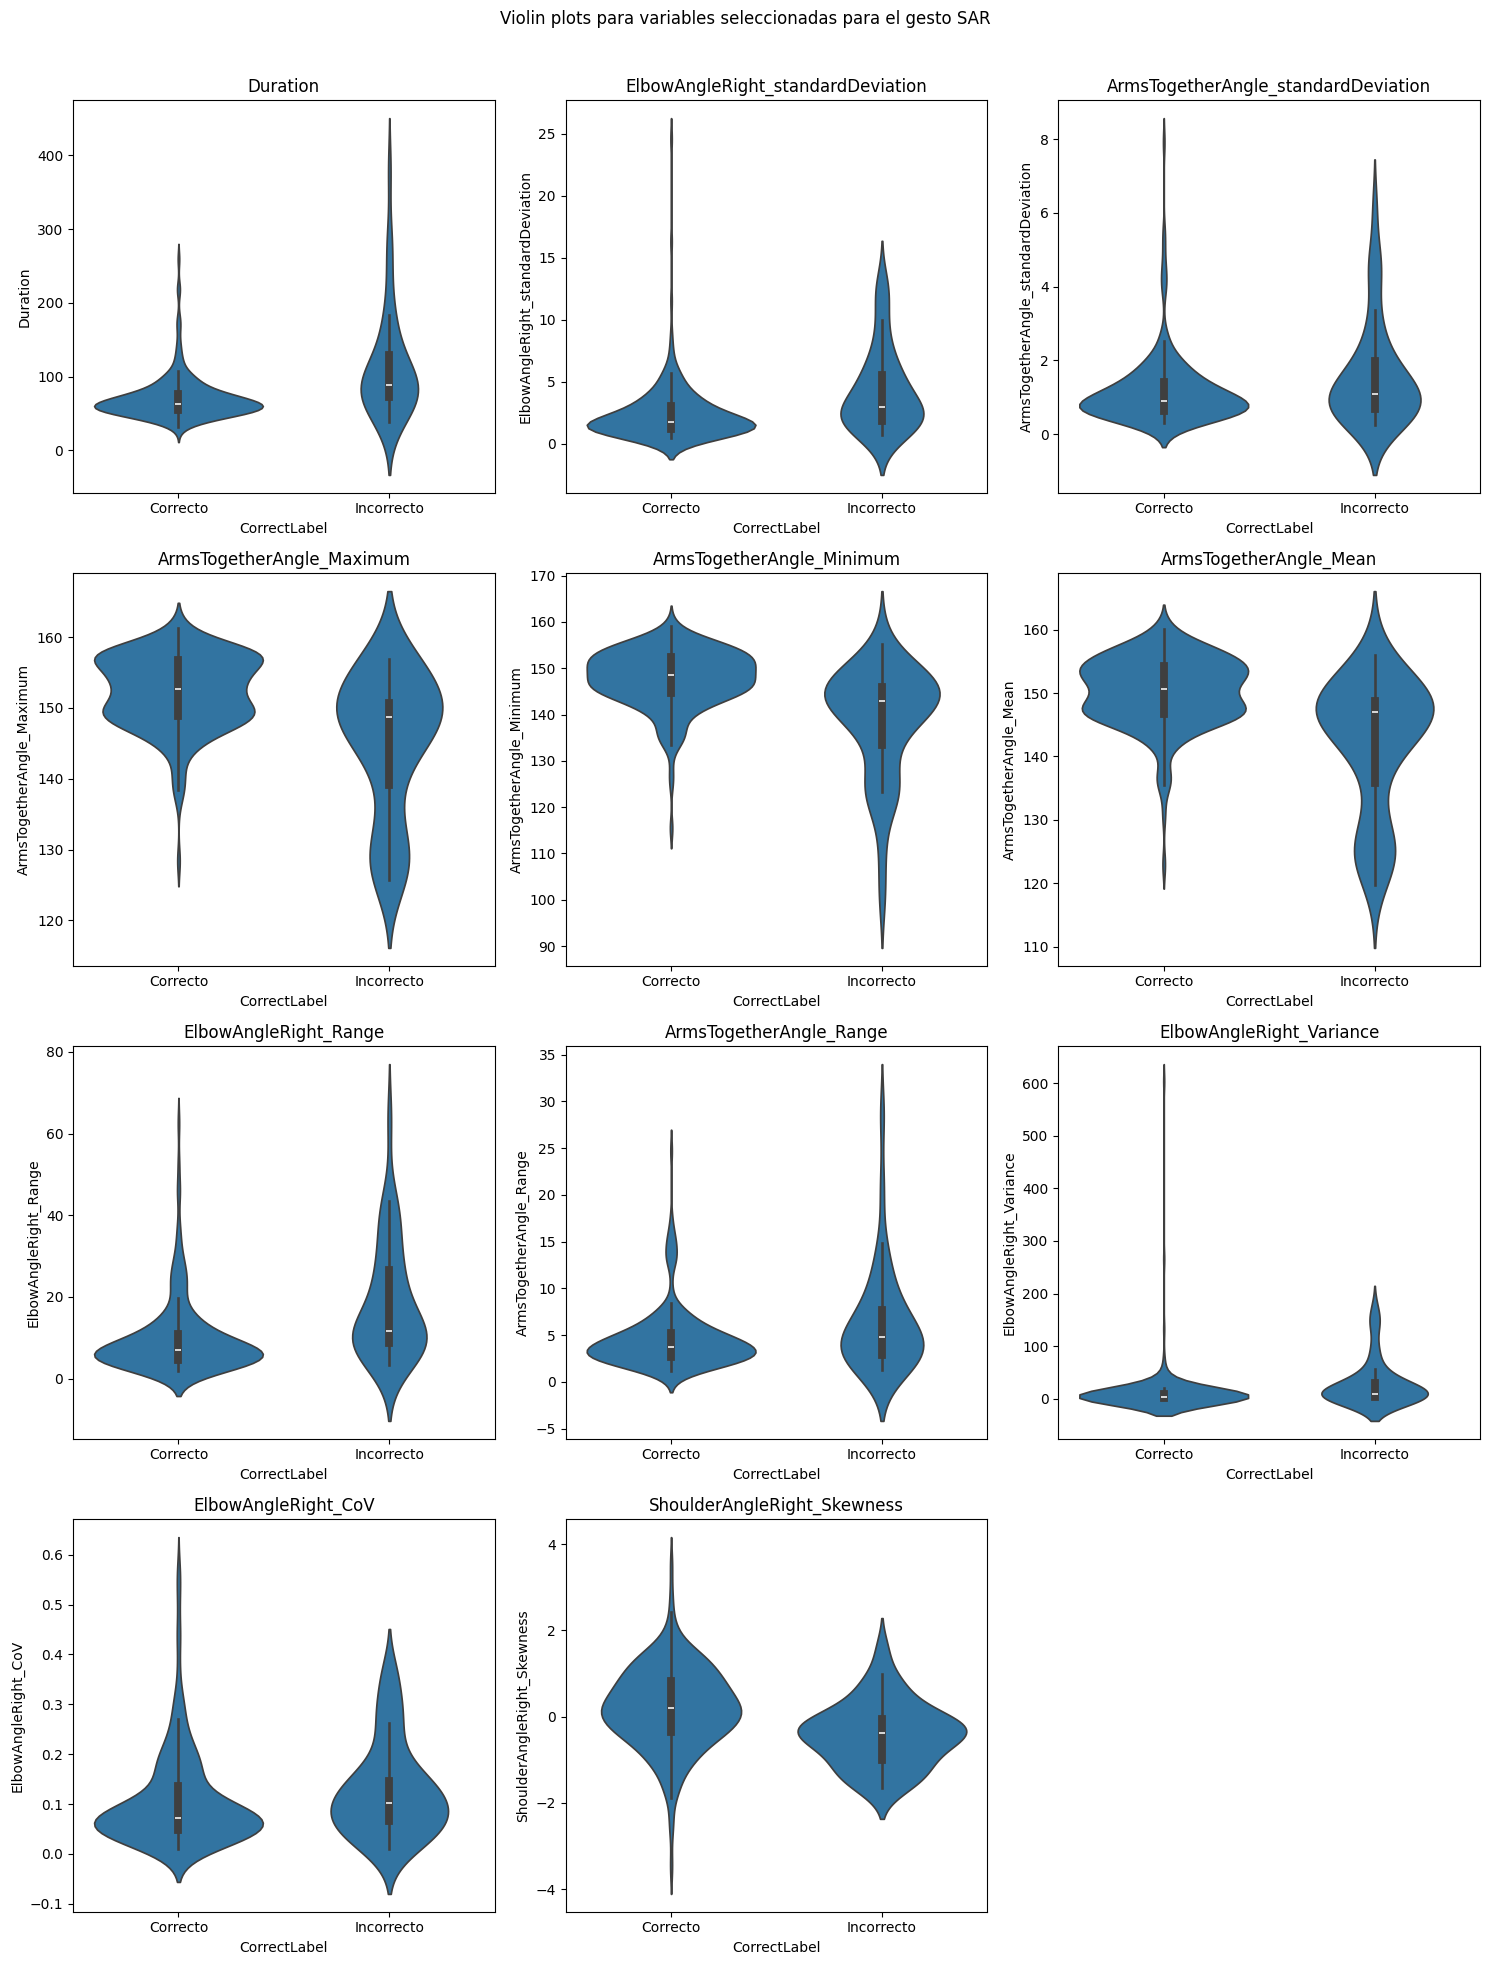

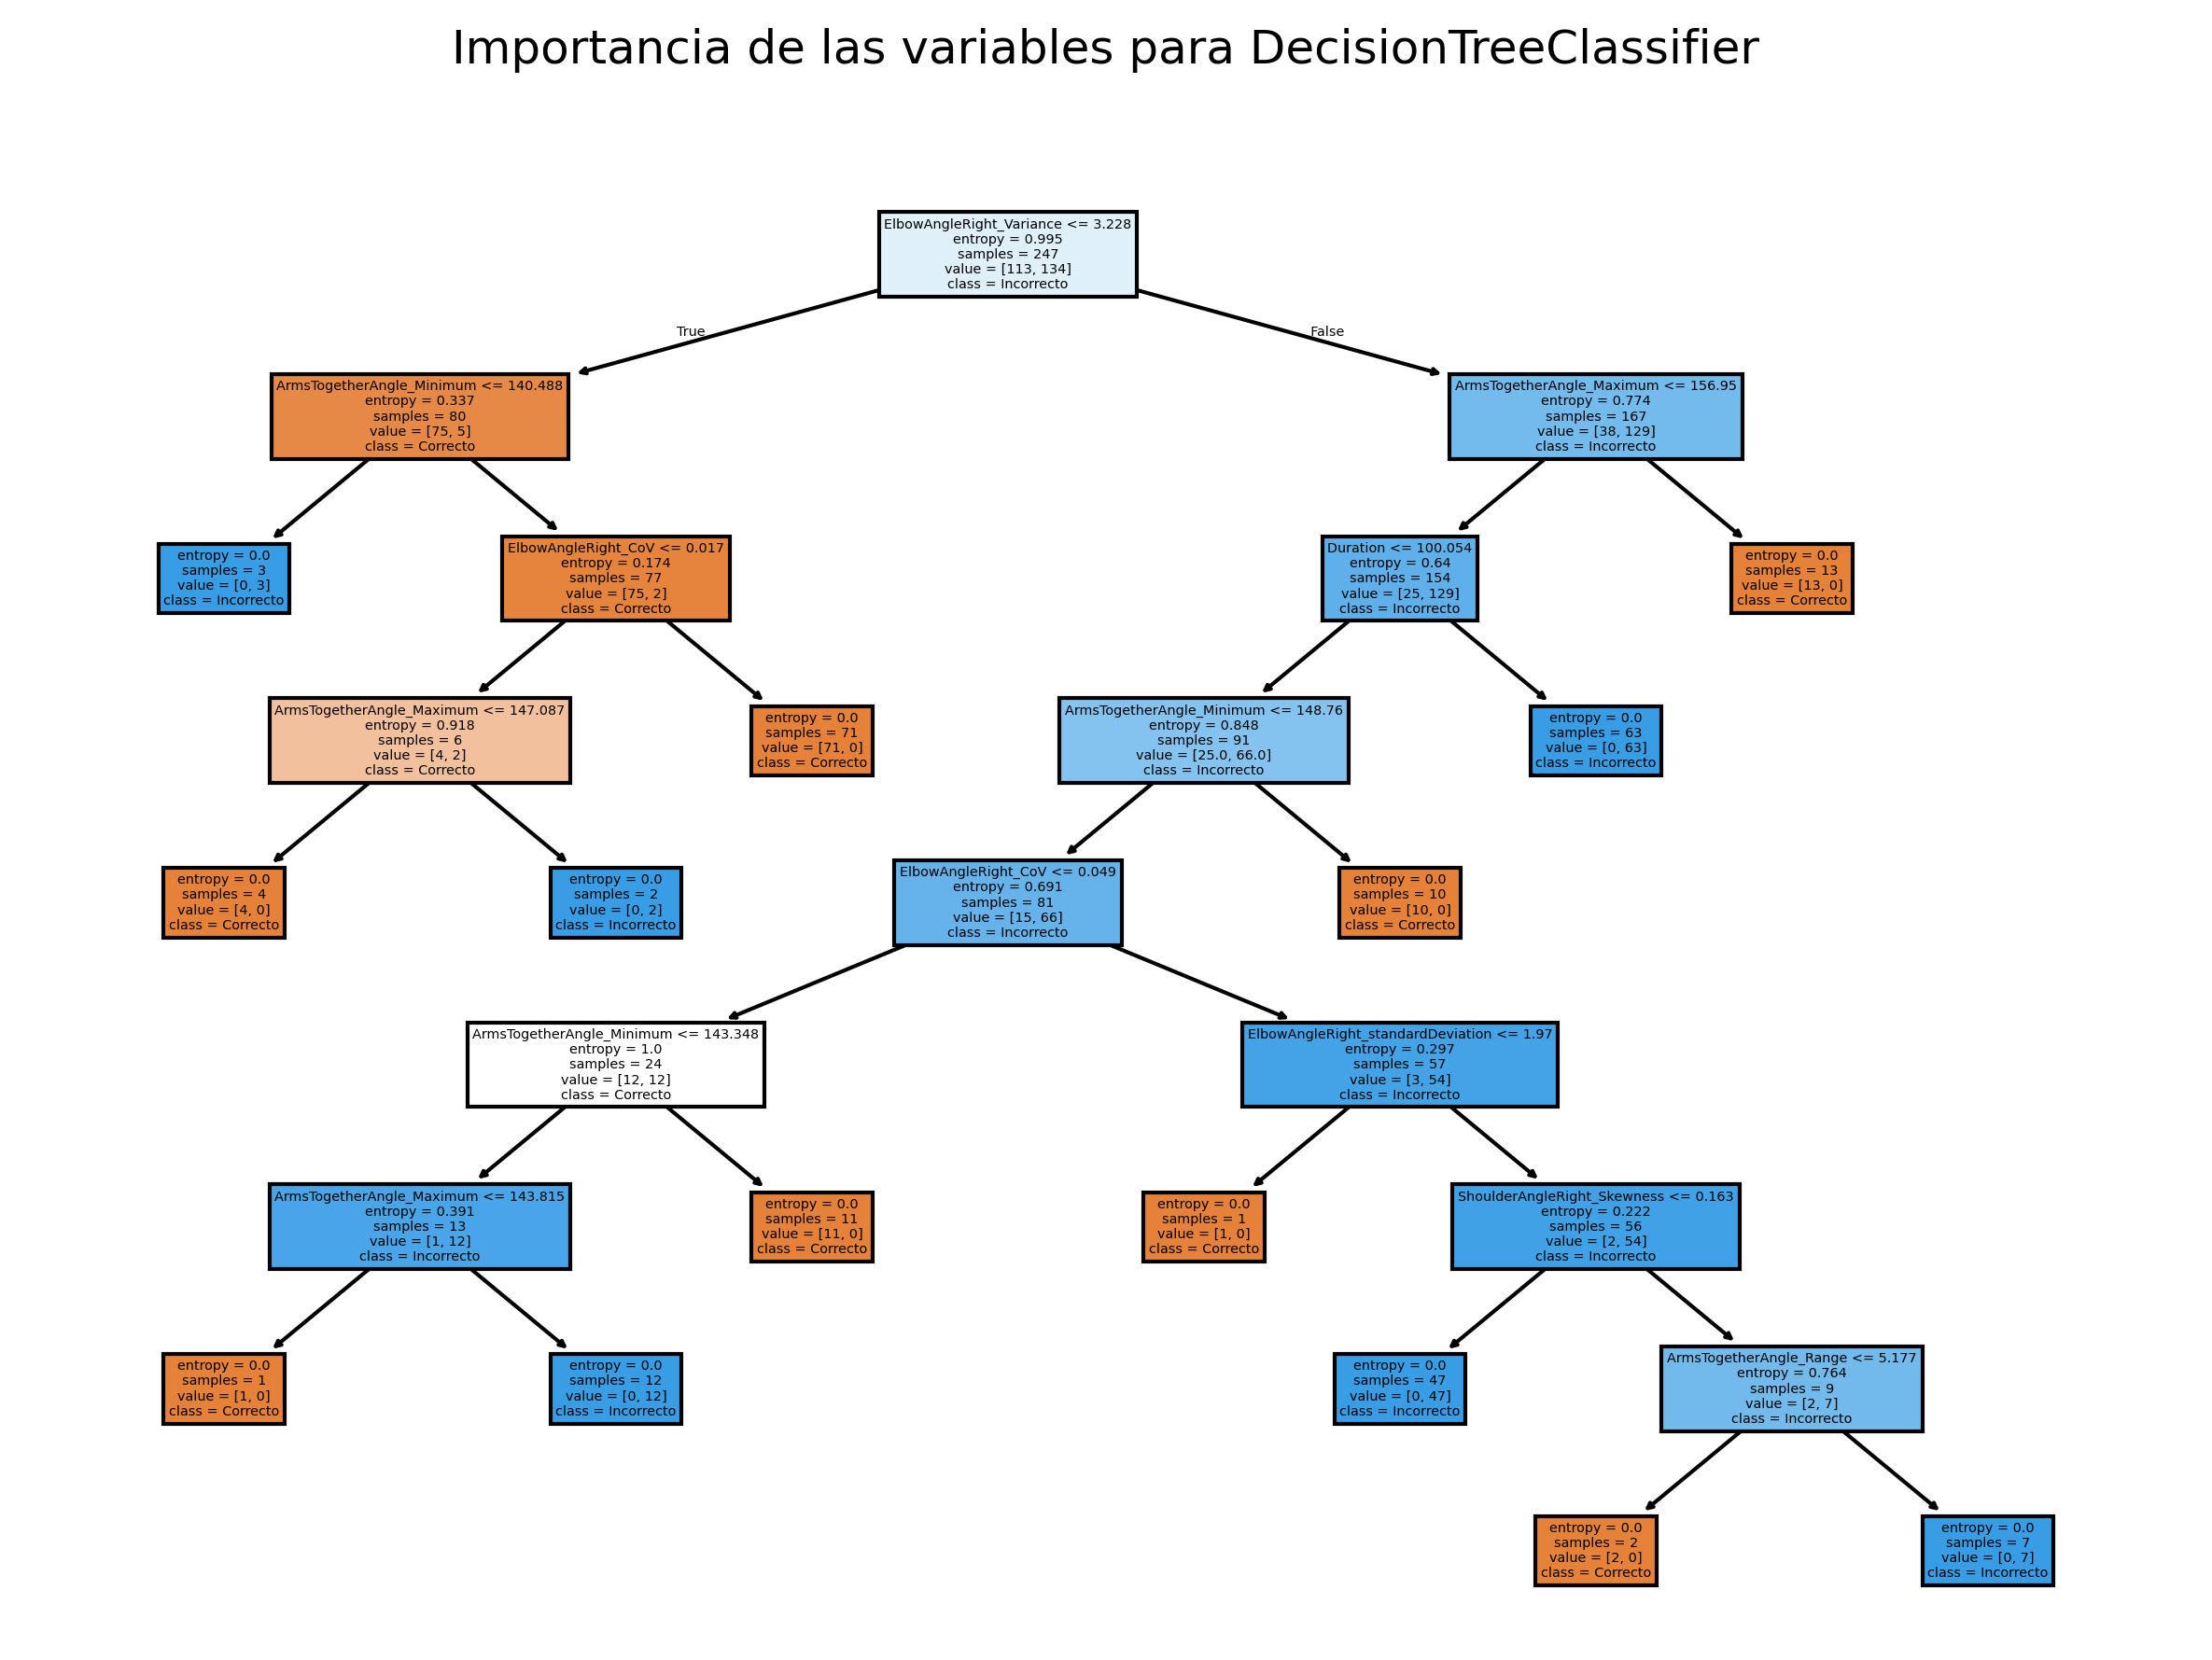

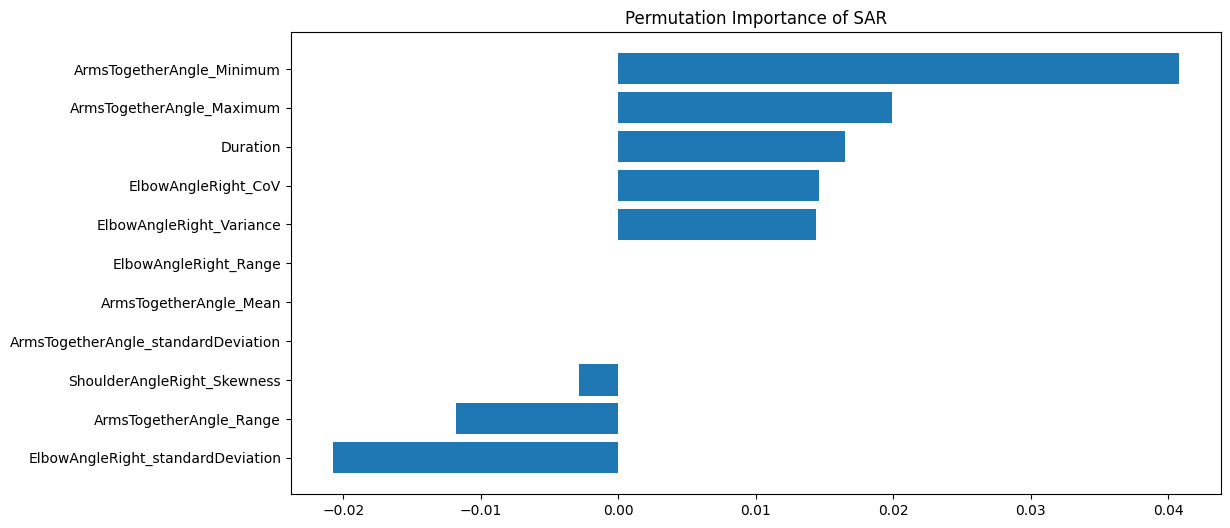


------------ CLASIFICACION GESTO SFE -----------

F1-score del conjunto de entrenamiento: 0.9456521739130435
F1-score del conjunto de prueba: 0.953125
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=7)),
                ('classifier', KNeighborsClassifier(n_neighbors=2))])


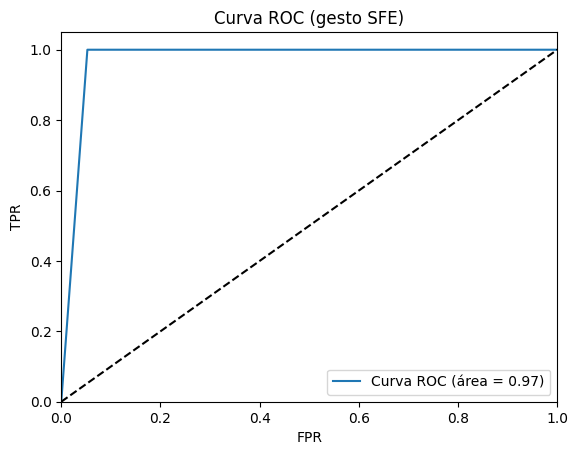

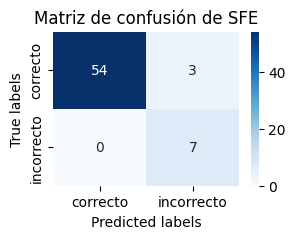

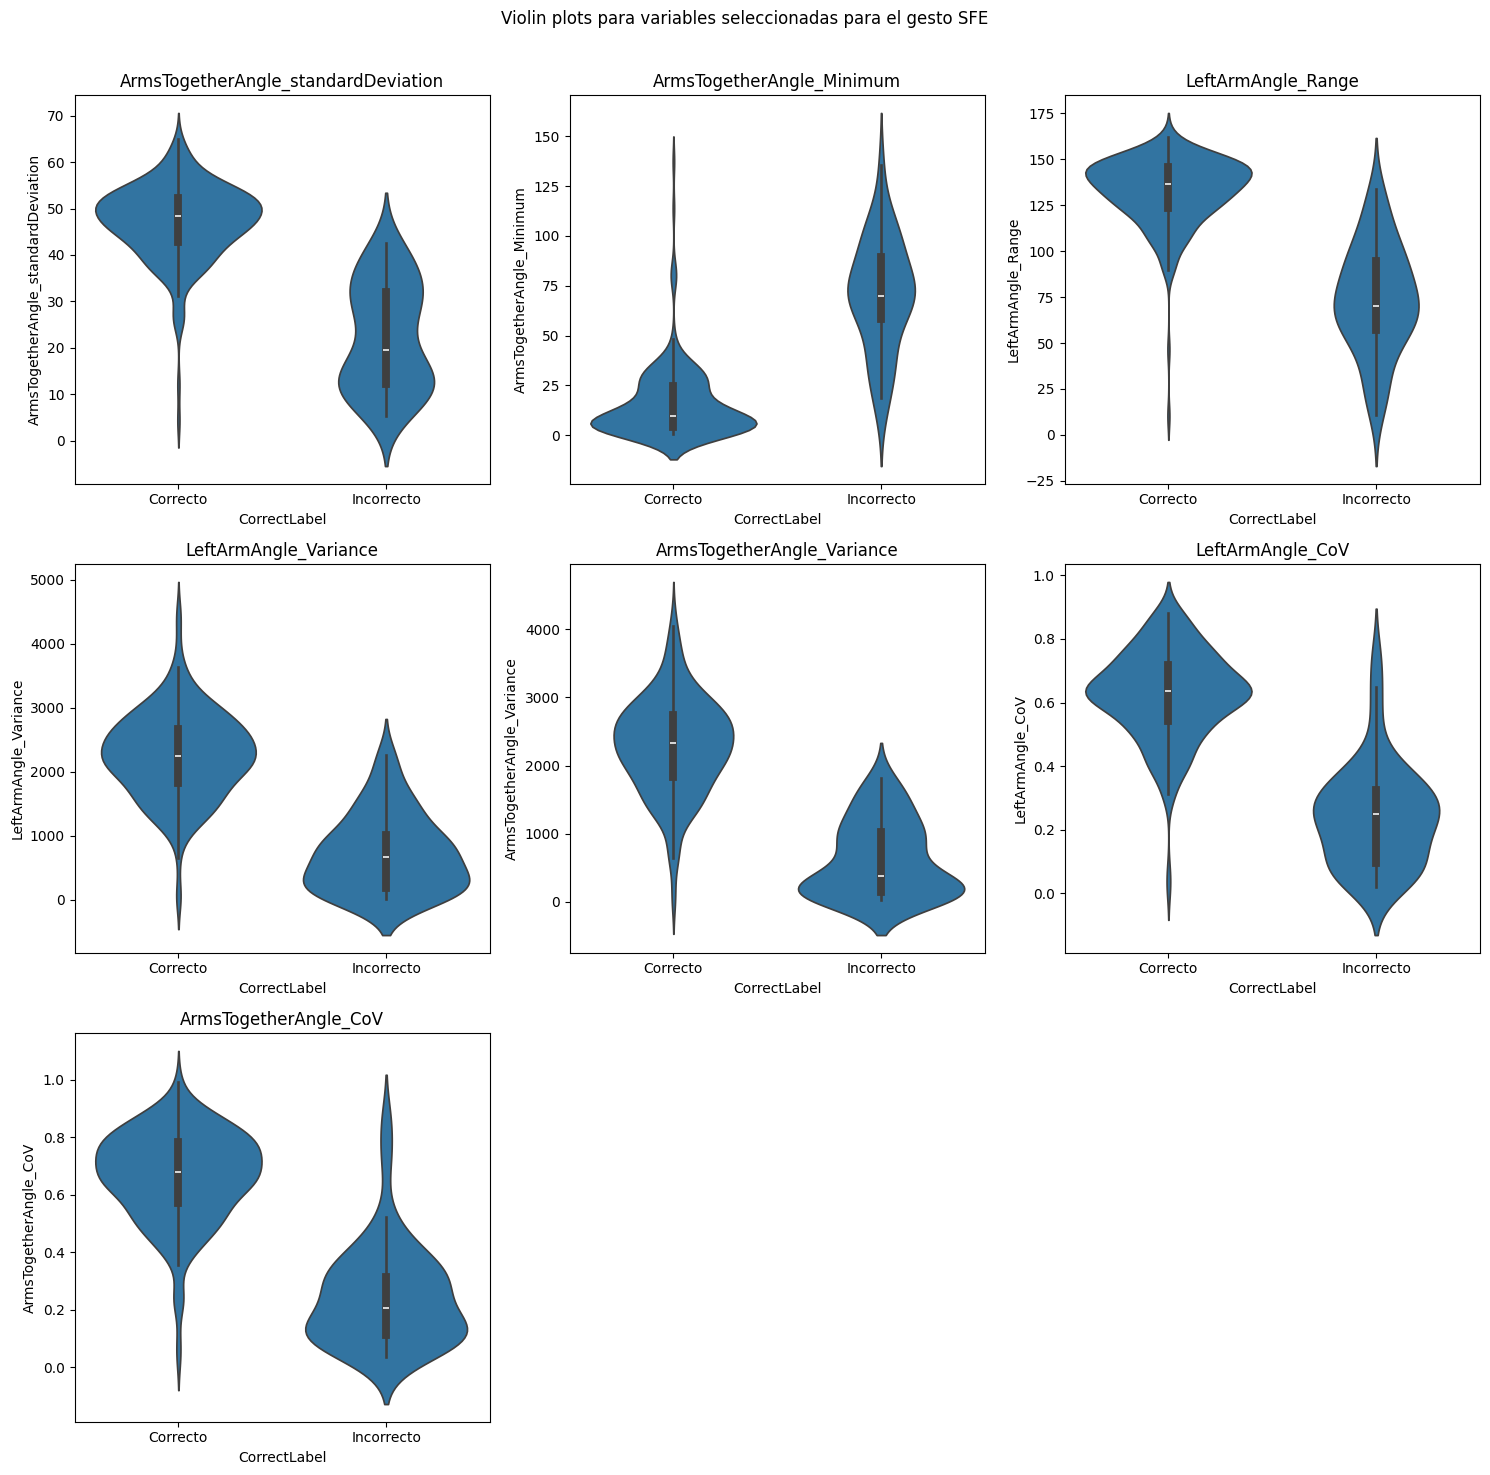

<Figure size 640x480 with 0 Axes>

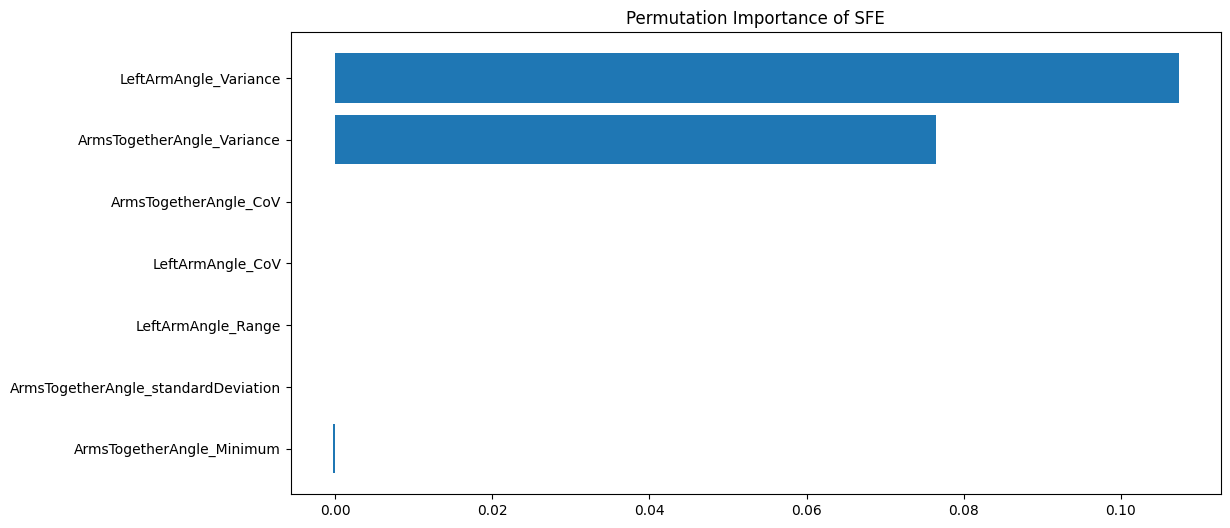


------------ CLASIFICACION GESTO STL -----------

F1-score del conjunto de entrenamiento: 0.8066298342541437
F1-score del conjunto de prueba: 0.7777777777777778
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTEENN(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=6)),
                ('classifier', LogisticRegression(C=0.01, max_iter=500))])


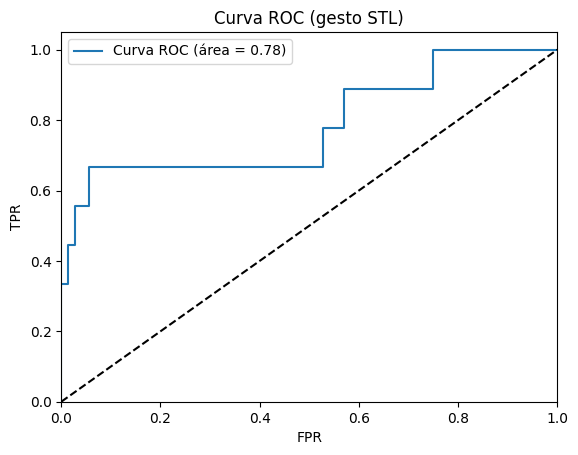

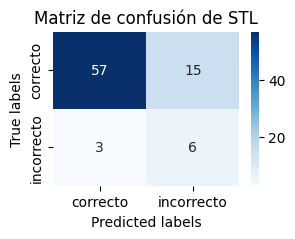

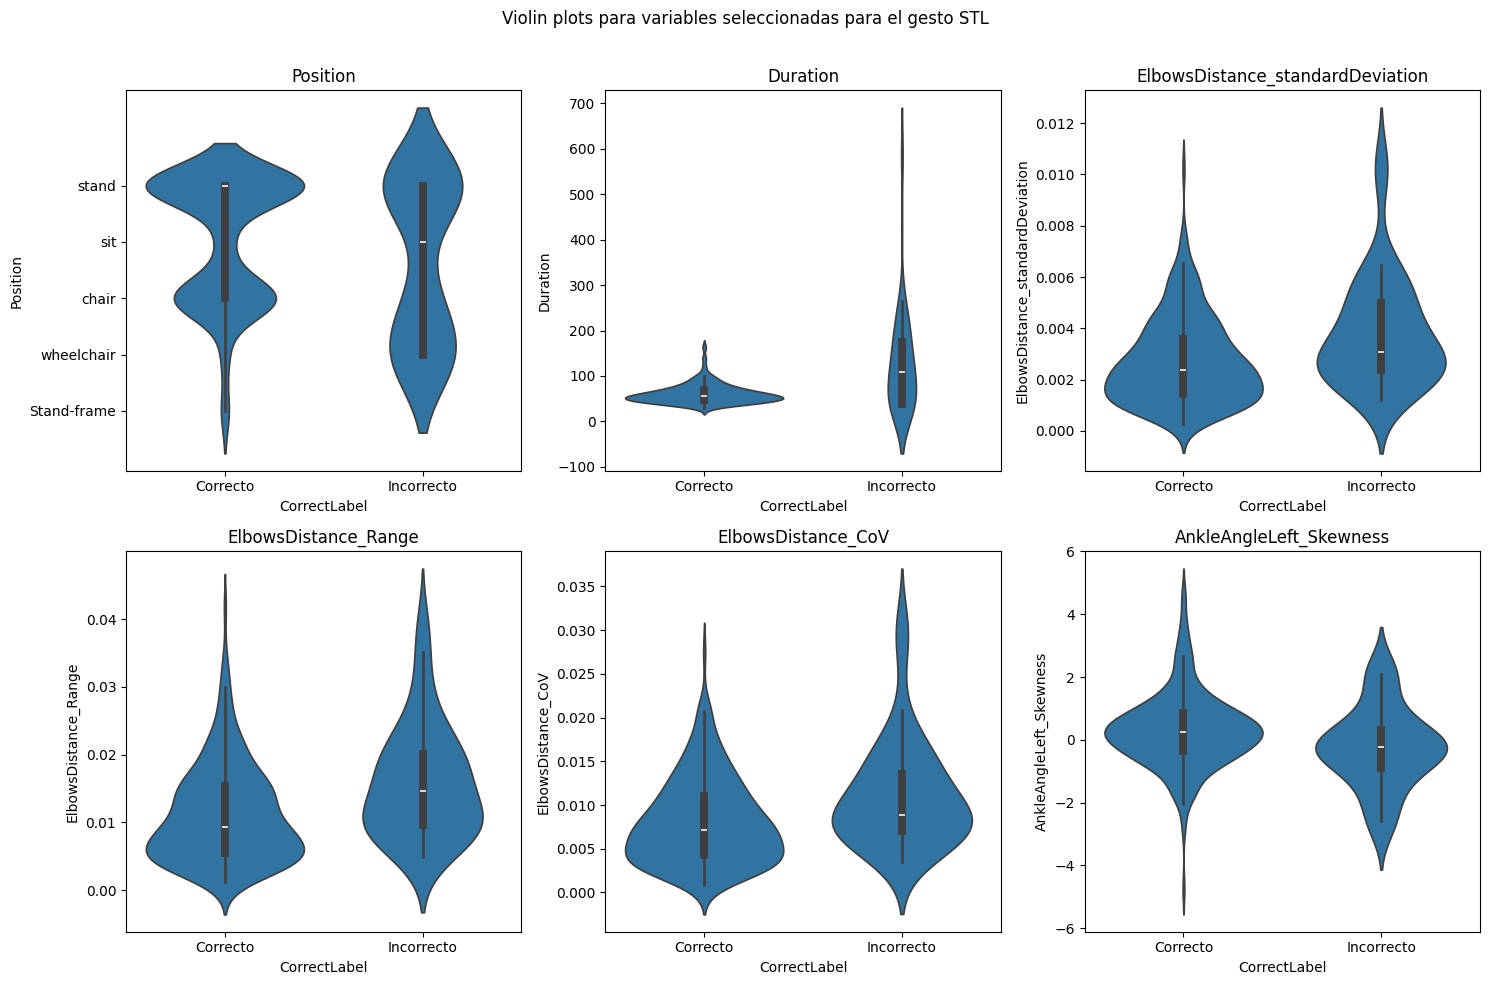

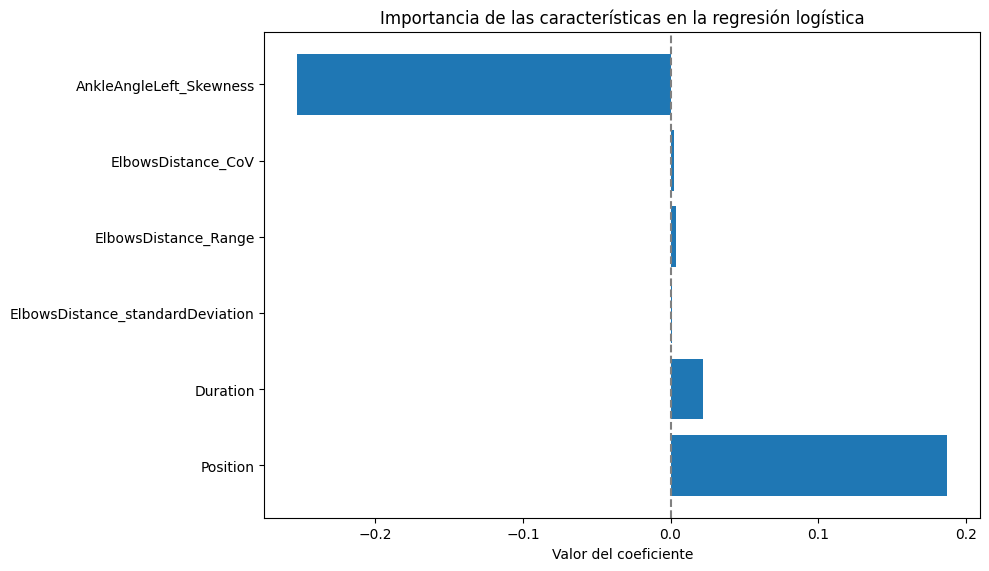


------------ CLASIFICACION GESTO STR -----------

F1-score del conjunto de entrenamiento: 0.8587570621468926
F1-score del conjunto de prueba: 0.7227722772277227
Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('encoder', OrdinalEncoder(),
                                                  ['Position'])])),
                ('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=6)),
                ('classifier',
                 GaussianNB(var_smoothing=4.4306214575838774e-08))])


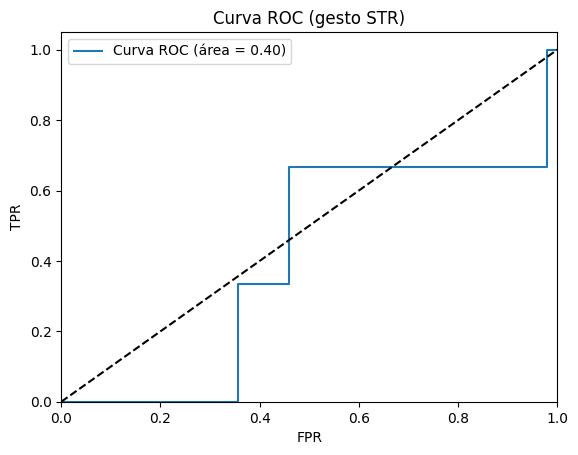

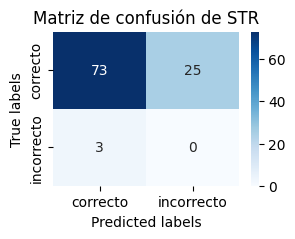

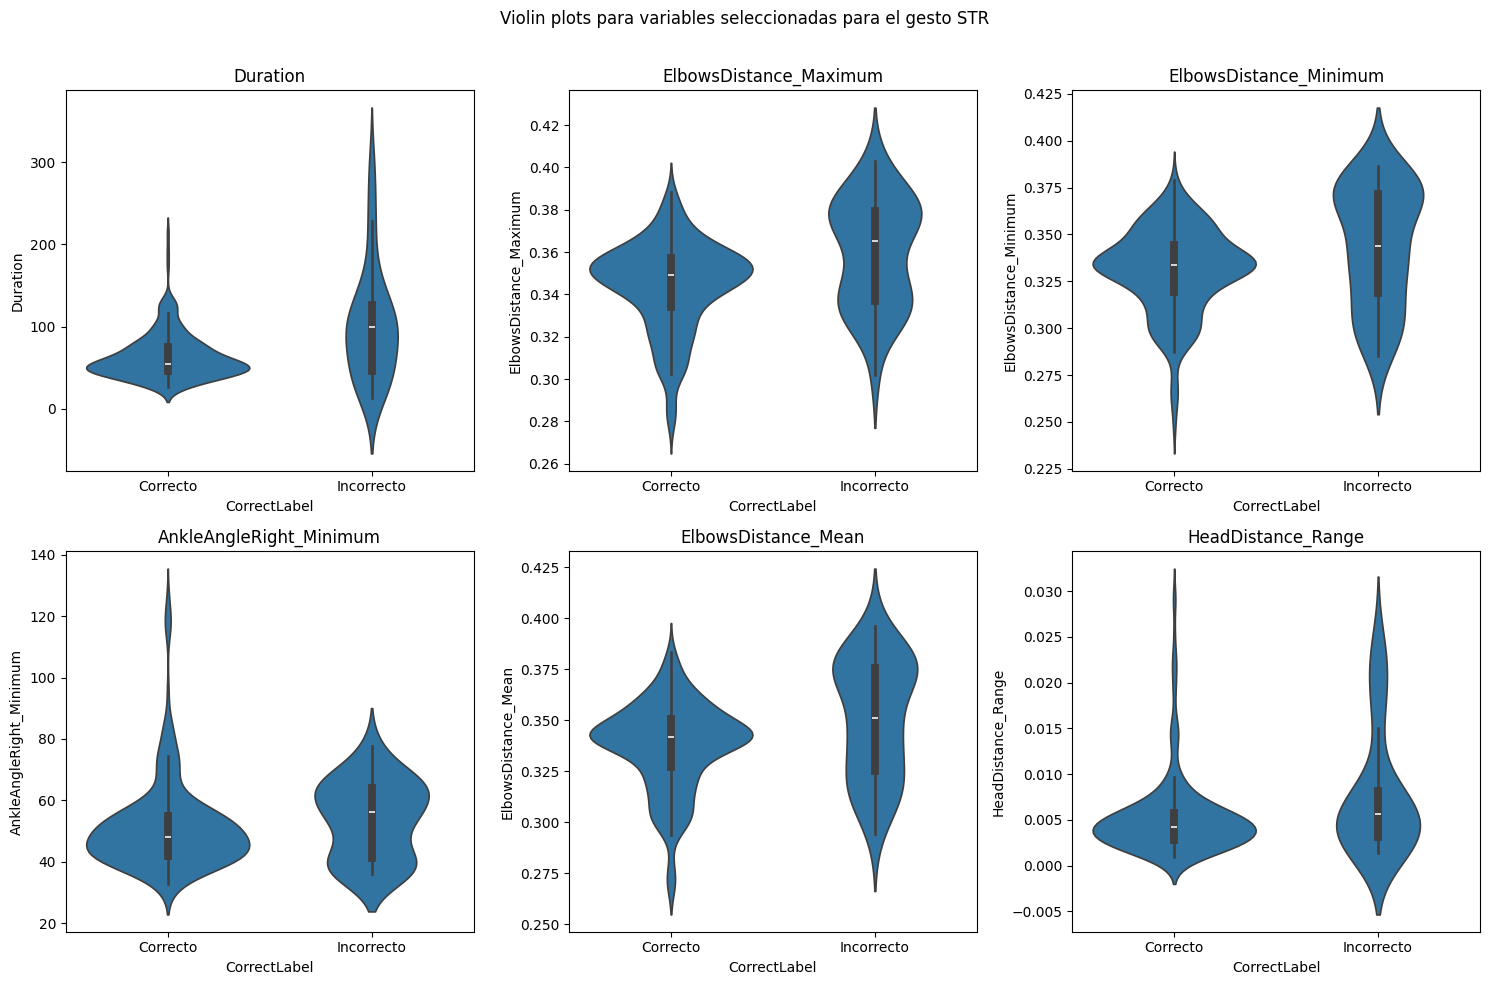

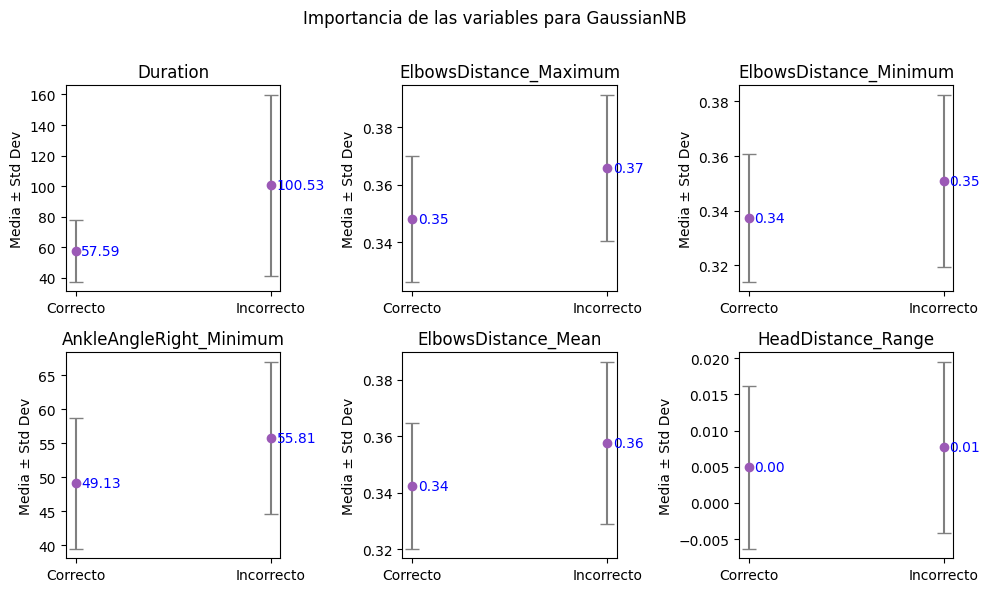

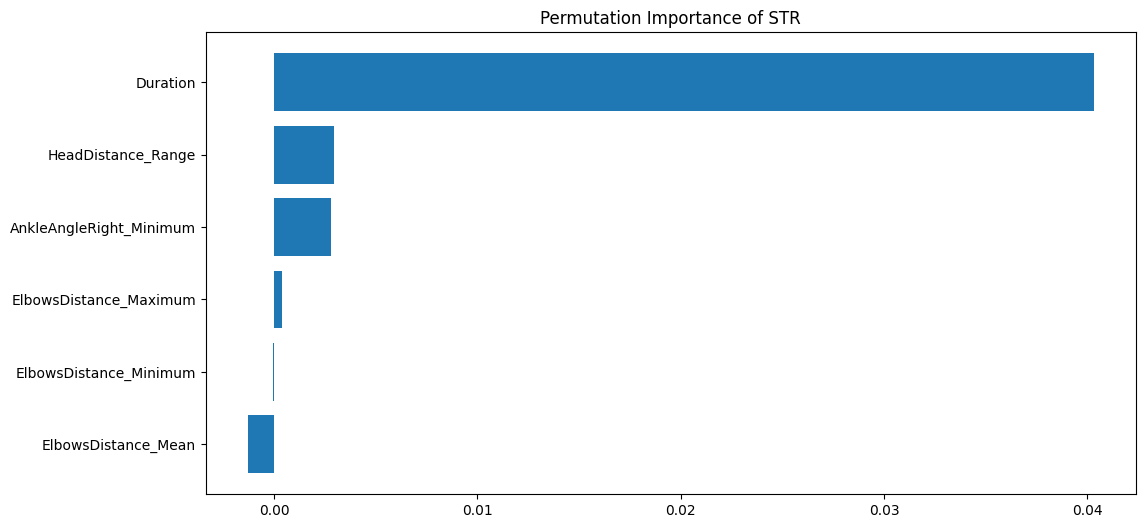

In [6]:
gestures = df_raw['GestureName'].unique()
logo = LeaveOneGroupOut()
results = []

for gesture in gestures:
    df_gesture = df_raw[df_raw['GestureName'] == gesture]

    angles = []

    #------- Calcular angulos y distancia segun gesto ---------
    if gesture == 'EFL' or gesture == 'SFL' or gesture == 'SAL' or gesture == 'SFE':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel', 'Position']]

            elbow_angle_left = fn.calculate_angle(group, 'ShoulderLeft', 'ElbowLeft', 'WristLeft')
            left_arm_angle = fn.calculate_angle(group, 'HipLeft', 'ShoulderLeft', 'ElbowLeft')
            wrist_angle_left = fn.calculate_angle(group, 'ElbowLeft', 'WristLeft', 'HandLeft')
            arms_together_angle = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'WristLeft')
            shoulder_angle_left = fn.calculate_angle(group, 'ShoulderLeft', 'SpineShoulder', 'ElbowLeft')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            hips_distance = calcular_distancia(group, 'HipLeft', 'HipRight')
            foots_distance = calcular_distancia(group, 'FootLeft', 'FootRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            # Almacenar la información en un diccionario
            angles.append({
                **additional_data,
                'ElbowAngleLeft': elbow_angle_left,
                'ShoulderAngleLeft': shoulder_angle_left,
                'WristAngleLeft': wrist_angle_left,
                'LeftArmAngle': left_arm_angle,
                'ArmsTogetherAngle': arms_together_angle,
                'ElbowsDistance': elbows_distance,
                'HipsDistance': hips_distance,
                'FootsDistance': foots_distance,
                'HeadDistance': head_distance
            })


    elif gesture == 'EFR'or gesture == 'SFR' or gesture == 'SAR':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel', 'Position']]

            elbow_angle_right = fn.calculate_angle(group, 'ShoulderRight', 'ElbowRight', 'WristRight')
            right_arm_angle = fn.calculate_angle(group, 'HipRight', 'ShoulderRight', 'ElbowRight')
            wrist_angle_right = fn.calculate_angle(group, 'ElbowRight', 'WristRight', 'HandRight')
            arms_together_angle = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'WristRight')
            shoulder_angle_right = fn.calculate_angle(group, 'ShoulderRight', 'SpineShoulder', 'ElbowRight')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            hips_distance = calcular_distancia(group, 'HipLeft', 'HipRight')
            foots_distance = calcular_distancia(group, 'FootLeft', 'FootRight')

            angles.append({
                **additional_data,
                'ElbowAngleRight': elbow_angle_right,
                'ShoulderAngleRight': shoulder_angle_right,
                'WristAngleRight': wrist_angle_right,
                'RightArmAngle': right_arm_angle,
                'ArmsTogetherAngle': arms_together_angle,
                'ElbowsDistance': elbows_distance,
                'HipsDistance': hips_distance,
                'FootsDistance': foots_distance,
                'HeadDistance': head_distance
            })

    elif gesture == 'STL':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel', 'Position']]

            hip_angle_left = fn.calculate_angle(group, 'HipLeft', 'SpineBase', 'KneeLeft')
            knee_angle_left = fn.calculate_angle(group, 'HipLeft', 'KneeLeft', 'AnkleLeft')
            ankle_angle_left = fn.calculate_angle(group, 'KneeLeft', 'AnkleLeft', 'FootLeft')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            angles.append({
                **additional_data,
                'HipAngleLeft': hip_angle_left,
                'KneeAngleLeft': knee_angle_left,
                'AnkleAngleLeft': ankle_angle_left,
                'ElbowsDistance': elbows_distance,
                'HeadDistance': head_distance
            })

    elif gesture == 'STR':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName', 'RepetitionNumber', 'CorrectLabel', 'Position']]

            hip_angle_right = fn.calculate_angle(group, 'HipRight', 'SpineBase', 'KneeRight')
            knee_angle_right = fn.calculate_angle(group, 'HipRight', 'KneeRight', 'AnkleRight')
            ankle_angle_right = fn.calculate_angle(group, 'KneeRight', 'AnkleRight', 'FootRight')

            elbows_distance = calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            head_distance = calcular_distancia(group, 'SpineShoulder', 'Head')

            angles.append({
                **additional_data,
                'HipAngleRight': hip_angle_right,
                'KneeAngleRight': knee_angle_right,
                'AnkleAngleRight': ankle_angle_right,
                'ElbowsDistance': elbows_distance,
                'HeadDistance': head_distance
            })

    # Crear un DataFrame a partir de la lista de diccionarios
    df_angles = pd.DataFrame(angles)

    # ---------- Agrupar por repeticion ----------
    # Agrupa el DataFrame 
    groups = df_angles.groupby(["SubjectID", "RepetitionNumber"])

    # Lista para almacenar los datos de salida
    data = []

    # Itera sobre cada grupo
    for (subject_id, repetition_number), group in groups:
        # Selecciona solo las columnas que contienen los ángulos 
        angles = group.iloc[:, 6:]

        # Calcula la media y la desviación estándar para los ángulos
        means = angles.mean()
        std_devs = angles.std()

        # Almacena las estadísticas en un diccionario 
        data.append({
            'SubjectID': subject_id,
            'RepetitionNumber': repetition_number,
            'CorrectLabel': group['CorrectLabel'].iloc[0],
            'Position': group['Position'].iloc[0],
            'Duration': len(group),  # Duración en número de frames
            'standardDeviation': std_devs,
            'Maximum': angles.max(),
            'Minimum': angles.min(),
            'Mean': means,
            'Range': angles.max() - angles.min(),
            'Variance': angles.var(),
            'CoV': std_devs / means,  # Coeficiente de variación
            'Skewness': angles.skew(),  # Asimetría
            'Kurtosis': angles.kurtosis()  # Curtosis
        })

    # Convierte la lista de diccionarios en un DataFrame y lo ordena
    df_stats = pd.DataFrame(data)
    df_stats = df_stats.apply(pd.to_numeric, errors='ignore')
    df_stats = df_stats.sort_values(['RepetitionNumber'])

    columnas = ['standardDeviation', 'Maximum', 'Minimum', 'Mean', 'Range',
                    'Variance', 'CoV', 'Skewness', 'Kurtosis']

    nuevas_columnas = pd.concat([fn.formatear_columnas(df_stats[col], col) for col in columnas], axis=1)

    df_stats = pd.concat([df_stats, nuevas_columnas], axis=1)

    df_stats = df_stats.drop(columnas, axis=1)
    # cambiar las poorly executed to incorrectly executed
    df_stats.loc[df_stats['CorrectLabel'] == 3, 'CorrectLabel'] = 2

    # --------- Copia fase 2 ---------
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_df_gestures(df_stats, 'CorrectLabel')
    print(f'\n------------ CLASIFICACION GESTO {gesture} -----------\n')

    # Crear el pipeline con técnicas de balanceo, selección de características, reducción de dimensión y modelo de clasificación
    pipeline = ImbPipeline([
        ('preprocessing', ColumnTransformer(
                            transformers=[('encoder',  OrdinalEncoder(), ['Position'])],
                            remainder='passthrough' ),
                        ),
        ('balance_data', SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))),
        ('select_features', SelectKBest(score_func=f_classif)),
        ('classifier', KNeighborsClassifier(n_neighbors=2))
    ])
    
    # RandomizedSearchCV para encontrar los mejores hiperparámetros
    random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1, n_iter=5, scoring='roc_auc')
    random.fit(X_train, y_train, groups=X_train['SubjectID'])
    
    # Mejor pipeline encontrado
    best_pipeline = random.best_estimator_

    # Evaluar el modelo en el conjunto de entrenamiento y prueba
    f1_score_train = best_pipeline.score(X_train, y_train)
    f1_score_test = best_pipeline.score(X_test, y_test)
    print(f'F1-score del conjunto de entrenamiento: {f1_score_train}')
    print(f'F1-score del conjunto de prueba: {f1_score_test}')
    print(best_pipeline)
    
    # Calcular la curva ROC
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=2)
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.figure()  
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC (gesto {gesture})')
    plt.legend()
    plt.show()

    # Matriz de confusión
    prediction = best_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index=['correcto', 'incorrecto'], columns=['correcto', 'incorrecto'])
    plt.figure(figsize=(3, 2))
    ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    ax.set_title(f'Matriz de confusión de {gesture}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()

    # Variables seleccionadas
    preprocessor = best_pipeline.named_steps['preprocessing']
    feature_names = preprocessor.get_feature_names_out()

    select_kbest = best_pipeline.named_steps['select_features']

    selected_features_mask = select_kbest.get_support()
    selected_features = feature_names[selected_features_mask]

    selected_features = [name.replace('remainder__', '') for name in selected_features]
    selected_features = [name.replace('encoder__', '') for name in selected_features]

    df_selected = df_stats[selected_features]
  
    y = df_stats['CorrectLabel'] 
    y_mapped = y.map({1: 'Correcto', 2: 'Incorrecto'})

    # Violin plots
    n_features = len(selected_features)
    n_cols = 3  
    n_rows = (n_features + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(selected_features):
        sns.violinplot(x=y_mapped, y=df_selected[feature], ax=axes[i])
        axes[i].set_title(f'{feature}') 
        axes[i].set_xlabel('CorrectLabel')
        axes[i].set_ylabel(feature)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Violin plots para variables seleccionadas para el gesto {gesture}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Prevent the supertitle from overlapping
    plt.show()

    # Visualizar los clasificadores
    classifier = best_pipeline.named_steps['classifier']
    classifier_name = classifier.__class__.__name__

    if classifier_name == 'GaussianNB':
        # Extract means and variances
        means = classifier.theta_
        variances = classifier.var_

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
        axes = axes.flatten()
    
        for i, feature in enumerate(selected_features):
            axes[i].errorbar([0, 1], means[:, i], yerr=np.sqrt(variances[:, i]),
                             fmt='o', capsize=5, color='#9b59b6',
                             ecolor='gray')
            for j in range(2):  
                axes[i].text(j+0.03, means[j, i], f'{means[j, i]:.2f}', 
                     ha='left', va='center', fontsize=10, color='blue')
            axes[i].set_title(f'{feature}')
            axes[i].set_xticks([0, 1])
            axes[i].set_xticklabels(['Correcto', 'Incorrecto'])
            axes[i].set_ylabel('Media ± Std Dev')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    elif classifier_name == 'DecisionTreeClassifier':
        fig = plt.figure(figsize=(8, 6), dpi=300) 
        tree.plot_tree(classifier,
                        feature_names=selected_features,
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled=True)

    elif classifier_name == 'LogisticRegression':
        coefficients = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, coefficients)
        plt.xlabel("Valor del coeficiente")
        plt.title("Importancia de las características en la regresión logística")
        plt.axvline(x=0, color="grey", linestyle="--")
      
    elif classifier_name == 'RandomForestClassifier':
        fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
        for index in range(0, 5):
            tree.plot_tree(classifier.estimators_[index],
                        feature_names=selected_features, 
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled = True,
                        ax = axes[index])
        axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
        plt.tight_layout()

    elif classifier_name == 'SVC' and classifier.kernel == 'linear':
        weights = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, weights, color='blue')
        plt.axvline(x=0, color='grey', linestyle='--')
        plt.xlabel("Valor del peso (Importancia de la característica)")
        plt.title("Importancia de las características en el clasificador SVC")

    fig.suptitle(f'Importancia de las variables para {classifier_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Prevent the supertitle from overlapping
    plt.show()

    # Permutation Importance
    if 'Position' not in selected_features: 
        perm_importance = permutation_importance(classifier, df_selected, y, scoring='f1',n_repeats=10)
        sorted_idx = perm_importance.importances_mean.argsort()
        fig = plt.figure(figsize=(12, 6))
        plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(df_selected.columns)[sorted_idx])
        plt.title(f'Permutation Importance of {gesture}')
        plt.show()

***• Resumen resultados***

In [8]:
pd.DataFrame(results)

Empty DataFrame
Columns: []
Index: []